# 해커톤 프로젝트 9조 마이러버(MYROBO)
#### 거시경제 지표와 주식시장과의 실증분석

- <주제> 주식 시장 예측

김태환: 유의미한 변수를 데이터로만 예측해보자.
 
김병준 : 텍스트 마이닝을 통한 감성분석, 개인투자자의 성향 파악해보자

김태용 : 볼린저 밴드 중심으로 20일 이동평균선을 활용해보자.

이현철 : LSTM, FFT 활용해서 예측해보자. 

- for 수업내용 복습 , 데이터 분석 및 활용을 최대화 
‘데이터 기반 예측’ 채택


##### <세부 주제 선정> ‘경제적 지표들을 활용하여 KOSPI 지수 예측하기’

- 1 ) 
삼성전자 주가를 중심으로 개별 기업 주가 예측 시도.
But 특정 기업에만 적용되는 예측이라면 기업 고유의 변수들이 존재(실적,액면분할 등),
또한 모델이 틀리면 무의미한 결과물이 될 리스크도 있음.
 

- 2 )
한 기업만을 90%확률로 예측하는 것보다
여러 기업을 70%확률로 예측하는 방향으로 
범용성을 가진 모델을 만들고 싶었음.
 

- 3 )
결국 한국 주식시장의 흐름과 가격은 
KOSPI로 파악 가능하기 때문에
KOSPI 지수 자체를 예측하기로 결정



#### 해커톤 일정

- 1.데이터 수집(04.23)

- 2.데이터 전처리(04.23~04.25)

- 3.데이터 확인, 분석방법 설정(04.25~04.26)

- 4.분석(04.26~05.01)

- 5.분석 결과 해석(04.28~05.03)

- 6.시각화(05.04)

# 중간발표 요약

### 1. 데이터 수집 및 데이터 전처리

##### Features 탐색
- kospi-코스피(일별) ---------------기준!
- samsung-삼성전자 (일별)
- CLI-경기선행지수순환변동치(월별) #2022 3,4월 평균처리
- sp500- S&P500 (일별) # 날짜 안맞아서 NA인 값들 한단위 전,후데이터 평균냄
- rate-환율(일별)
- volume-코스피거래량(일별)
- EXIM-경상수지(월별) #2022 3,4월 평균처리

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import FinanceDataReader as fdr
import pandas as pd

kospi = fdr.DataReader('KS11','2017-01-01')
samsung = fdr.DataReader('005930', "2017-01-01")
# CLI = () #from bank of korea (https://ecos.bok.or.kr/)
sp500=fdr.DataReader('US500','2017-01-01')
rate = fdr.DataReader('USD/KRW', '2017-01-01')
# volume = ()#Volume column of kospi 
# exim = ()#from bank of korea (https://ecos.bok.or.kr/)


In [2]:
pd.DataFrame.to_csv(samsung['Close'],'삼성종가.csv')
pd.DataFrame.to_csv(kospi['Close'],'코스피.csv')
pd.DataFrame.to_csv(sp500['Close'],'S&P500.csv')
pd.DataFrame.to_csv(rate['Close'],'환율.csv')
pd.DataFrame.to_csv(kospi['Volume'],'거래량.csv')
# CLI, EXIM은 바로 csv 파일을 내려받아 활용, 
# volume은 Kospi DF에서 추출

In [3]:
data=pd.read_csv('./First.csv')

#### 2017년 01월 ~ 22년 04월 까지의 데이터
 ##### 기간 설정 이유: 처음엔 2000년 01월부터의 데이터를 가져왔으나 데이터의 수가 너무 많아 전처리에 어려움을 느꼈고,<br/>오래된 데이터의 한계때문에 최근 시장상황을 예측하는데 유의미한 영향을 미치지 못 할 것이라고 생각하였다.

In [4]:
data

,date,kospi,samsung,sp500,cli,volume,exim,rate
0,2017.1.2,2026.16,36100,2257.83,100.3,229880000,3401.7,1203.93
1,2017.1.3,2043.97,36480,2257.83,100.3,268130000,3401.7,1206.82
2,2017.1.4,2045.64,36160,2270.75,100.3,371490000,3401.7,1196.15
3,2017.1.5,2041.95,35560,2269.00,100.3,541340000,3401.7,1182.19
4,2017.1.6,2049.12,36200,2276.98,100.3,455350000,3401.7,1202.00
...,...,...,...,...,...,...,...,...
1300,2022.4.19,2718.89,67300,4462.21,99.8,1260000000,6200.0,1239.53
1301,2022.4.20,2718.69,67400,4459.45,99.8,1740000000,6200.0,1233.66
1302,2022.4.21,2728.21,67700,4393.66,99.8,1000000000,6200.0,1242.81
1303,2022.4.22,2704.71,67000,4271.78,99.9,1240000000,6200.0,1244.11


##### 결측치 확인

In [5]:
data.isnull().sum()

date       0
kospi      0
samsung    0
sp500      0
cli        0
volume     0
exim       0
rate       0
dtype: int64

## 피쳐들간 상관계수 확인
- kospi(target)과 삼성주가, s&p500, 경기선행지수(CLI) 의 상관성이 높은 것을 파악

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = data.corr()   # 상관관계 리턴
corr

,kospi,samsung,sp500,cli,volume,exim,rate
kospi,1.000000,0.897369,0.793182,0.728984,0.479541,0.266201,-0.237155
samsung,0.897369,1.000000,0.896903,0.452069,0.652677,0.219672,0.045463
sp500,0.793182,0.896903,1.000000,0.247781,0.526511,0.188858,0.285166
cli,0.728984,0.452069,0.247781,1.000000,0.117565,0.244065,-0.554617
volume,0.479541,0.652677,0.526511,0.117565,1.000000,0.095520,0.094024
exim,0.266201,0.219672,0.188858,0.244065,0.095520,1.000000,-0.106586
rate,-0.237155,0.045463,0.285166,-0.554617,0.094024,-0.106586,1.000000


#### 상관계수 Heatmap
kospi는 samsung, s&p500, cli(경기선행지수)와 강한 상관관계를 갖고 있음을 확인함

<AxesSubplot:>

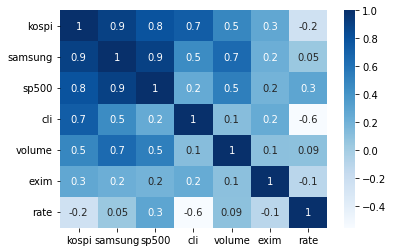

In [7]:
sns.heatmap(corr,annot=True,fmt='.1g',cmap='Blues') 

## Linear Regression
'samsung', 'cli', 'sp500', 'rate', 'volume', 'exim' 피쳐들을 가지고 선형회귀 모델 돌려보기
(사이킷런 활용)

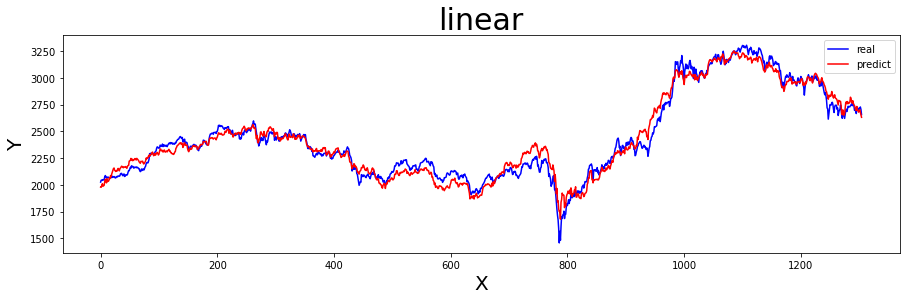

In [8]:
from sklearn import linear_model #선형회귀 라이브러리
# ['samsung', 'kospi', 'cli', 'sp500', 'rate', 'volume', 'exim']
X_data = data[['samsung','sp500', 'cli', 'volume', 'rate',  'exim']] #데이터 프레임에서의 컬럼 변수 값들 추출
Y_data = data['kospi'] #데이터 프레임에서의 종속변수 즉, 반응 변수

#다중선형회귀 모델 설계 Part
linear_regression_model = linear_model.LinearRegression() 
linear_regression_model.fit(X = pd.DataFrame(X_data), y = Y_data)
linear_regression_model_prediction = linear_regression_model.predict(X = pd.DataFrame(X_data))

#다중회귀분석 실제값 / 예측값 시각화 Part
fig = plt.figure( figsize = (15, 4))
graph = fig.add_subplot(1,1,1)
graph.plot(Y_data[:], color='blue', label='real')
graph.plot(linear_regression_model_prediction[:], color='red', label='predict')
graph.set_title('linear', size=30)
plt.xlabel('X', size=20)
plt.ylabel('Y', size=20)
plt.legend(loc = 'best')

## R-square, MSE, RMSE, 회귀계수, y절편 확인     

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
print('score=',linear_regression_model.score(X=pd.DataFrame(X_data),y=Y_data))
print('MSE=',mean_squared_error(linear_regression_model_prediction,Y_data))
print('RMSE=',mean_squared_error(linear_regression_model_prediction,Y_data)**0.5)

score= 0.968760510485541
MSE= 4823.078203818028
RMSE= 69.44838517790049


In [10]:
linear_regression_model.coef_

array([ 9.38604088e-03,  2.50826234e-01,  1.33480497e+02, -4.58587079e-09,
       -1.62546505e+00, -1.86433137e-04])

In [11]:
linear_regression_model.intercept_

-10355.45208159497

## 중간발표 피드백

- Q1_왜 KOSPI 예측을 위한 피쳐들을 ['samsung', 'cli', 'sp500', 'rate', 'volume', 'exim'] 들로 선정했는가?<br/>
  A1_팀원들간의 상의로 가장 영향력 있을 것 같은 변수들을 찾았다.<br/>

    [삼성]-KOSPI의 대표종목<br/>

    [S&P500]- 미국 주가 <br/>

    [환율]- 외국인들의 영향력 <br/>


    [거래량]- 거래량이 많으면 주가 변동이 클 것이라고 예상함

    [경상수지]- 이 수치가 경기에 영향력을 끼치는 시기와 정도가 애매모호하고, 발표가 늦게나서 시장예측에 반영하기 어려움 ->변수 제거
    
    [경기선행지수]- 주가와 경기상황이 관계가 깊을 것이라고 예상함


- Q2_다중공선성 문제는 확인해 보았는가?<br/>
  A2_ 경기선행지수에 KOSPI 가 포함되어 있어 공선성 문제가 있음을 인지<br/> 
삼성과 s&p500, cli의 막대한 영향력을 해소할 방법 고민 ->
    PCA, 피쳐 재선별 진행 결정<br/>
    
      경기선행 지수안에 있는 KOSPI를 뺀 나머지인
      재고순환지수(INT), 경제심리지수(ESI), 기계류 내수출하지수(DE), 건설수주액(COA), 수출입물가비율(TPI) 장단기금리차(SPREAD)를 채택  

***********************

*********************************

# 최종 발표 --------------------------------------------

# 1. 데이터 수정

### 최종 완성된 csv파일
 DATE : KOSPI 날짜 ---------------기준!<br/>

 KOSPI : KOSPI 마감지수<br/>
 
 SAMSUNG : SAMSUNG 종가<br/>

 SP500 : S&P500 마감지수 (기준일자 하루 전 데이터를 가져옴, WHY? S&P 마감지수는 KOSPI 개장 전에 알수있음) <br/> 

        ex)현재 5월4일 오전 8시, S&P 마감지수는 5월4일 오전 6시에 알 수 있음. 그 값이 FinanceDataReader엔 5월3일 데이터로 들어가 있음

            -> KOSPI 마감지수를 예측하는데에 당일 S&P500 마감지수를 사용할 수 있음

 VOLUME : KOSPI 거래량<br/>

 RATE : USD/KRW 환율 (기준일자 하루 전 데이터를 가져옴, WHY? 환율 공시 오후8시)<br/>


     KOSPI를 제외한 경기선행지수(경기에 반영되는 기간을 고려하여 KOSPI기준 4개월 전부터 데이터를 가져옴)
      ex)2020년 5월 25일 데이터: 2020년 1월 지수)<br/>

 INT : 재고순환지수 (경제의 재고순환과정 측정지표) <br/>

 ESI : 경제심리지수 (기업과 소비자의 경제전망 심리지표)<br/>

 DE : 기계류 내수출하지수 (기업의 설비투자 지표)<br/>

 COA : 건설수주액 (국내 건설경기의 대표지수)<br/>

 TPI : 수출입물가비율 (수출입상품의 가격동향)<br/>

 SPREAD : 장단기금리차(5년 국고채 유통 수익률 월평균 금리 - 1일물 무담보콜금리의 월평균 금리)<br/>

# 2. EDA(모델 학습 전 자료 탐색)

In [12]:
data=pd.read_csv('./data.csv')
data

,DATE,KOSPI,SAMSUNG,SP500,VOLUME,RATE,INT,ESI,DE,COA,TPI,SPREAD
0,2017년 1월 2일 월요일,2026.16,36100,2257.83,229880,1203.93,0.9,96.9,102.1,13855.4,100.3,0.05
1,2017년 1월 3일 화요일,2043.97,36480,2257.83,268130,1203.93,0.9,96.9,102.1,13855.4,100.3,0.05
2,2017년 1월 4일 수요일,2045.64,36160,2257.83,371490,1206.82,0.9,96.9,102.1,13855.4,100.3,0.05
3,2017년 1월 5일 목요일,2041.95,35560,2270.75,541340,1196.15,0.9,96.9,102.1,13855.4,100.3,0.05
4,2017년 1월 6일 금요일,2049.12,36200,2269.00,455350,1182.19,0.9,96.9,102.1,13855.4,100.3,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2022년 4월 27일 수요일,2639.06,65000,4175.20,1070000,1260.67,-8.1,105.4,103.0,14313.2,89.6,1.25
1307,2022년 4월 28일 목요일,2667.49,64800,4183.96,899170,1266.27,-8.1,105.4,103.0,14313.2,89.6,1.25
1308,2022년 4월 29일 금요일,2695.05,67400,4287.50,962400,1272.11,-8.1,105.4,103.0,14313.2,89.6,1.25
1309,2022년 5월 2일 월요일,2687.45,67300,4221.44,859940,1263.53,-7.8,105.4,104.8,15292.1,89.0,1.15


In [13]:
A=data[['KOSPI','SAMSUNG','SP500','VOLUME','RATE','INT','ESI','DE','COA','TPI','SPREAD']]
X=A.drop(['KOSPI'],axis=1)
X
Y=A['KOSPI']

## KOSPI를 포함한 모든 변수들의 상관관계 확인

<AxesSubplot:>

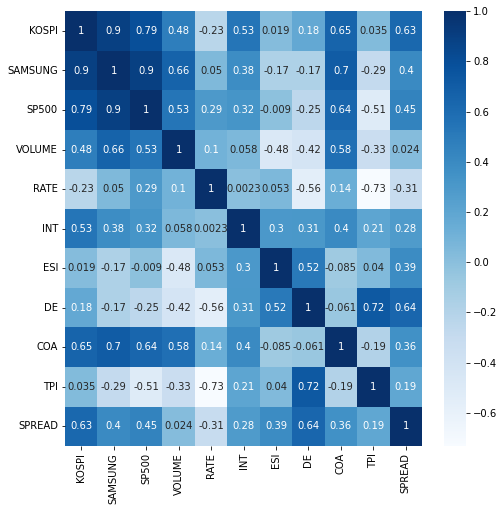

In [14]:
corr = A.corr()   # 상관관계 리턴
plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True,fmt='.2g',cmap='Blues')

## pairplot

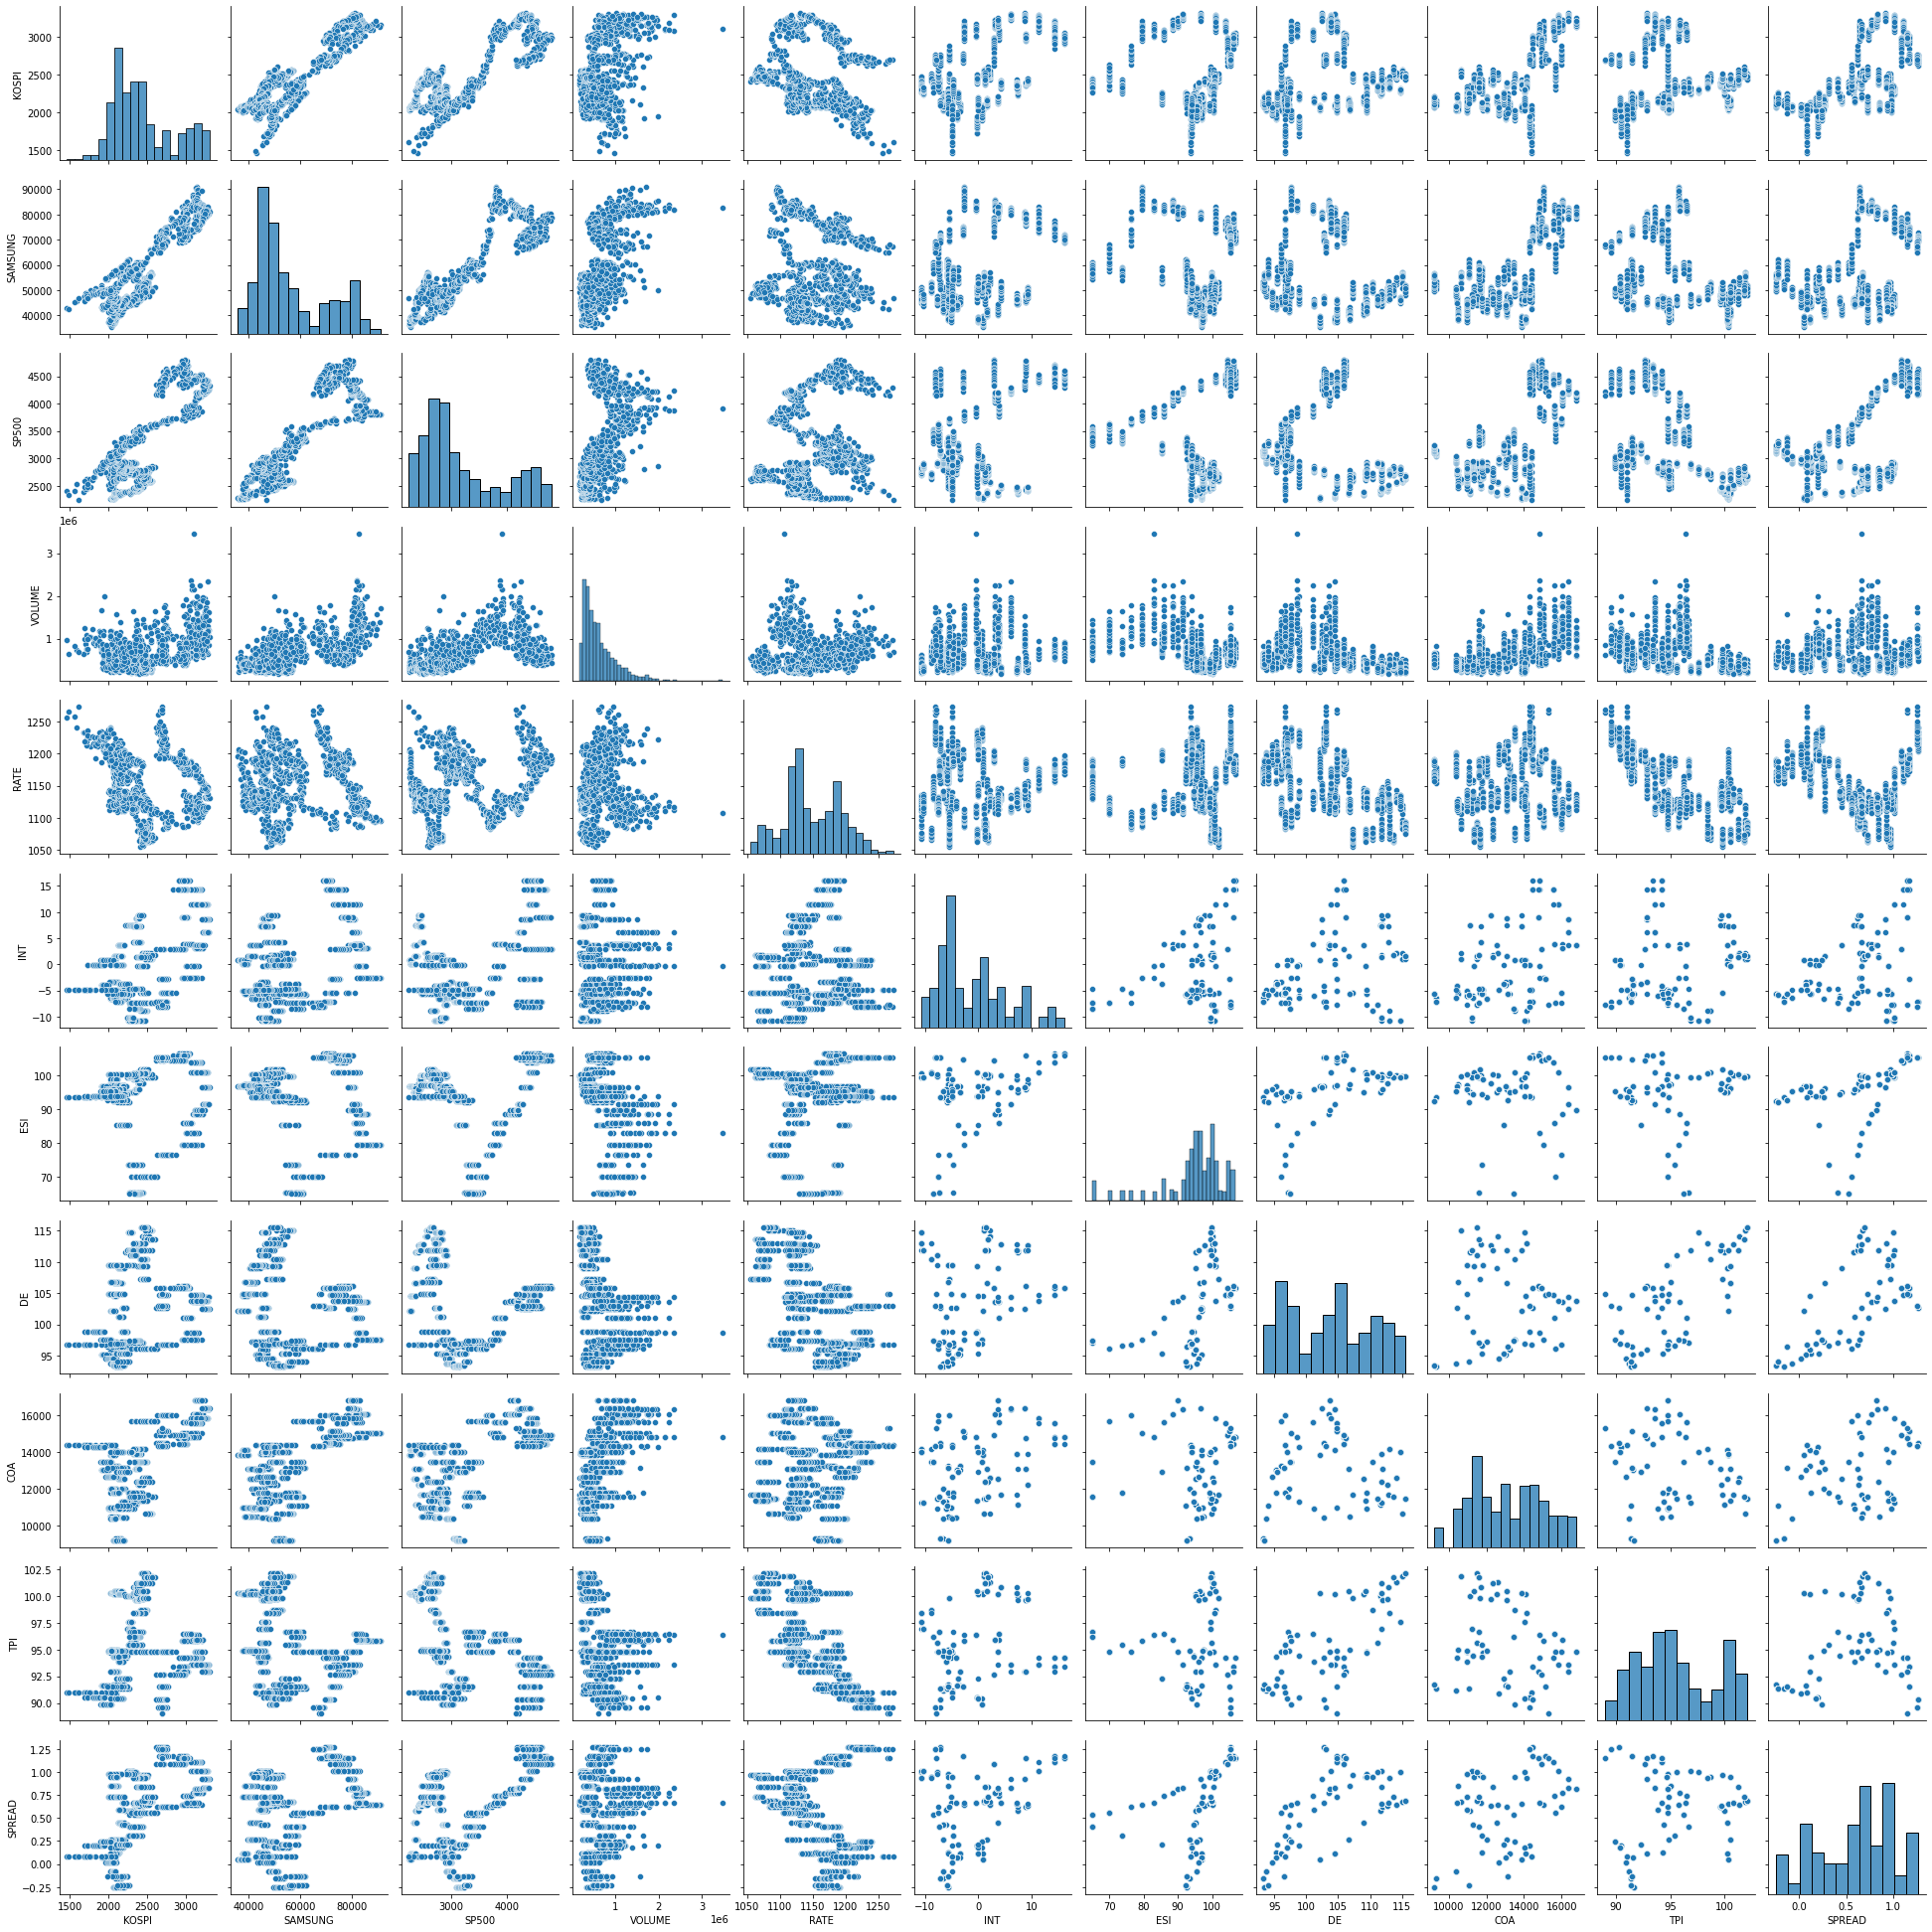

<Figure size 432x432 with 0 Axes>

In [15]:
sns.pairplot(data)
plt.figure(figsize=(6,6))
plt.show()

In [16]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
print(vif)


    VIF Factor features
0     1.551716      INT
1    10.714868   VOLUME
2    23.132976   SPREAD
3   125.989990      COA
4   217.849087  SAMSUNG
5   301.249757      ESI
6   341.469925    SP500
7  1037.206998     RATE
8  2048.982926      TPI
9  2820.727447       DE


In [17]:
res = ols('KOSPI ~ SAMSUNG+SP500+VOLUME+RATE+INT+ESI+DE+TPI+SPREAD+COA', data=A).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  KOSPI   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4372.
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        14:40:01   Log-Likelihood:                -7366.2
No. Observations:                1311   AIC:                         1.475e+04
Df Residuals:                    1300   BIC:                         1.481e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    197.9622    185.421      1.068      0.286    -165.794     561.719
SAMSUNG        0.0141      0.000     29.784      0.000       0.013       0.015
SP500          0.2278      0.011     21.529      0.000       0.207       0.249
VOLUME      4.421e-05   8.36e-06      5.285      0.000    2.78e-05    6.06e-05
RATE          -1.7986      0.078    -23.089      0.000      -1.951      -1.646
INT            6.8746      0.418     16.431      0.000       6.054       7.695
ESI            3.2990      0.354      9.318      0.000       2.605       3.994
DE            -1.5847      0.946     -1.676      0.094      -3.440       0.271
TPI           26.4260      1.362     19.404      0.000      23.754      29.098
SPREAD        78.6752     12.432      6.328      0.000      54.286     103.065
COA            0.0032      0.002      2.043      0.041       0.000       0.006
==============================================================================
Omnibus:                       11.212   Durbin-Watson:                   0.099
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.996
Skew:                          -0.050   Prob(JB):                     0.000336
Kurtosis:                       3.532   Cond. No.                     7.44e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## StandardScaler 활용하여 데이터 표준화 진행

In [18]:
from sklearn.preprocessing import StandardScaler

std_A = StandardScaler().fit_transform(A)
std_A = pd.DataFrame(std_A, index=A.index, columns=A.columns)
std_Y=std_A['KOSPI']
std_X=std_A.drop(['KOSPI'],axis=1)

In [19]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(std_X.values, i) for i in range(std_X.shape[1])]
vif["features"] = std_X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
print(vif)

   VIF Factor features
0    2.192553      INT
1    2.522012      COA
2    2.908409   VOLUME
3    2.984691      ESI
4    3.409619     RATE
5    6.985101      TPI
6    7.352689   SPREAD
7   11.478003       DE
8   12.526413  SAMSUNG
9   16.991593    SP500


In [20]:
res = ols('KOSPI ~ SAMSUNG+SP500+VOLUME+RATE+INT+ESI+DE+TPI+SPREAD+COA', data=std_A).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  KOSPI   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4372.
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        14:40:01   Log-Likelihood:                 463.29
No. Observations:                1311   AIC:                            -904.6
Df Residuals:                    1300   BIC:                            -847.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.179e-16      0.005  -1.74e-13      1.000      -0.009       0.009
SAMSUNG        0.4968      0.017     29.784      0.000       0.464       0.530
SP500          0.4183      0.019     21.529      0.000       0.380       0.456
VOLUME         0.0425      0.008      5.285      0.000       0.027       0.058
RATE          -0.2009      0.009    -23.089      0.000      -0.218      -0.184
INT            0.1147      0.007     16.431      0.000       0.101       0.128
ESI            0.0759      0.008      9.318      0.000       0.060       0.092
DE            -0.0268      0.016     -1.676      0.094      -0.058       0.005
TPI            0.2417      0.012     19.404      0.000       0.217       0.266
SPREAD         0.0809      0.013      6.328      0.000       0.056       0.106
COA            0.0153      0.007      2.043      0.041       0.001       0.030
==============================================================================
Omnibus:                       11.212   Durbin-Watson:                   0.099
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.996
Skew:                          -0.050   Prob(JB):                     0.000336
Kurtosis:                       3.532   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'SPREAD')

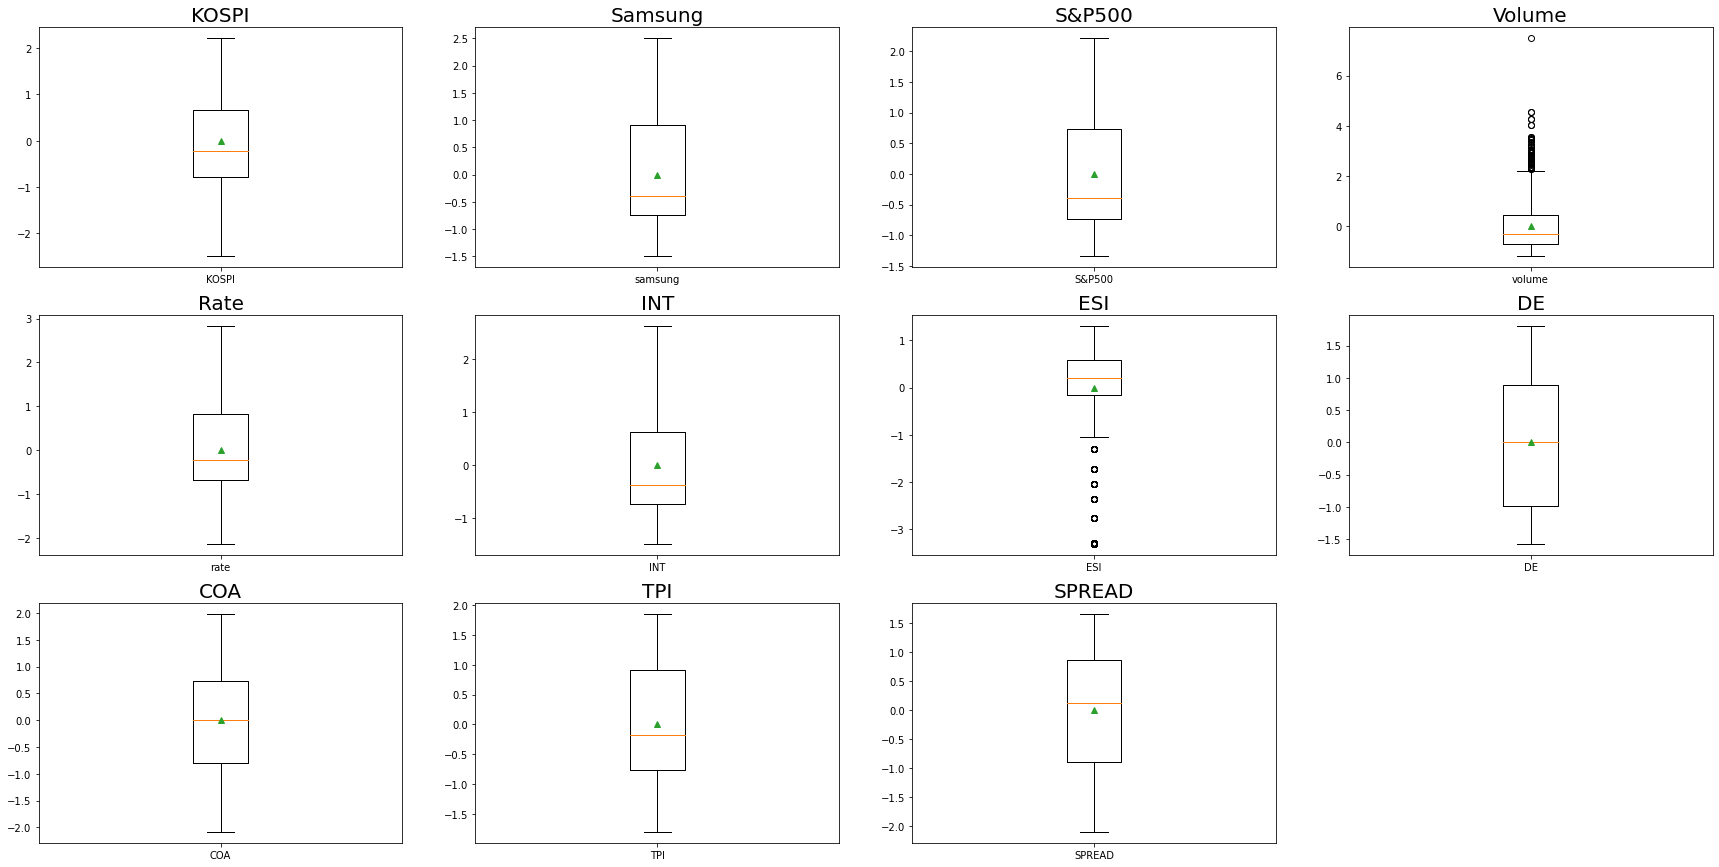

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,15))

plt.subplot(3, 4,1) 
plt.boxplot(std_A['KOSPI'], labels=['KOSPI'], showmeans=True)
plt.title('KOSPI', fontsize=20)

plt.subplot(3, 4,2) 
plt.boxplot(std_A['SAMSUNG'], labels=['samsung'], showmeans=True)
plt.title('Samsung', fontsize=20)

plt.subplot(3, 4,3) 
plt.boxplot(std_A['SP500'], labels=['S&P500'], showmeans=True)
plt.title('S&P500', fontsize=20)

plt.subplot(3, 4,4) 
plt.boxplot(std_A['VOLUME'], labels=['volume'], showmeans=True)
plt.title('Volume', fontsize=20)
plt.subplot(3, 4,5) 
plt.boxplot(std_A['RATE'], labels=['rate'], showmeans=True)
plt.title('Rate', fontsize=20)

plt.subplot(3, 4,6) 
plt.boxplot(std_A['INT'], labels=['INT'], showmeans=True)
plt.title('INT', fontsize=20)

plt.subplot(3, 4,7) 
plt.boxplot(std_A['ESI'], labels=['ESI'], showmeans=True)
plt.title('ESI', fontsize=20)

plt.subplot(3, 4,8) 
plt.boxplot(std_A['DE'], labels=['DE'], showmeans=True)
plt.title('DE', fontsize=20)

plt.subplot(3, 4,9) 
plt.boxplot(std_A['COA'], labels=['COA'], showmeans=True)
plt.title('COA', fontsize=20)

plt.subplot(3, 4,10) 
plt.boxplot(std_A['TPI'], labels=['TPI'], showmeans=True)
plt.title('TPI', fontsize=20)

plt.subplot(3, 4,11) 
plt.boxplot(std_A['SPREAD'], labels=['SPREAD'], showmeans=True)
plt.title('SPREAD', fontsize=20)

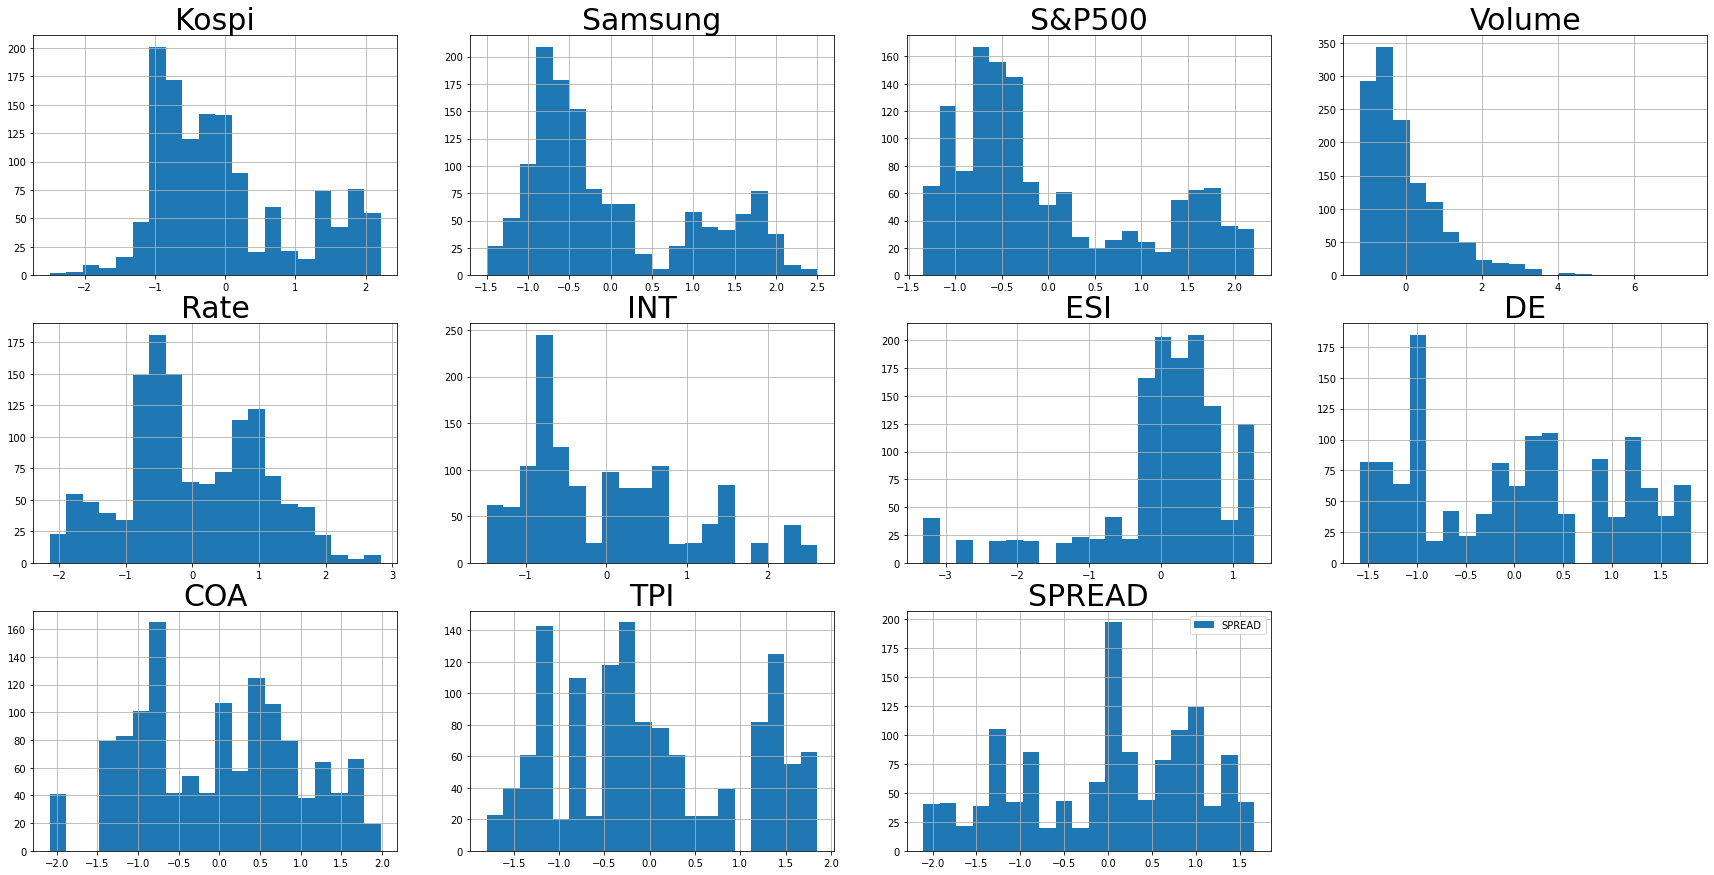

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30,15))

plt.subplot(3, 4,1) 
std_A['KOSPI'].hist(bins=20, grid=True, label='kospi')  #grid:눈금 , bin:클수록 막대 가늘어짐
plt.title('Kospi', fontsize=30)

plt.subplot(3, 4,2) 
std_A['SAMSUNG'].hist(bins=20, grid=True, label='Samsung')  #grid:눈금 , bin:클수록 막대 가늘어짐
plt.title('Samsung', fontsize=30)

plt.subplot(3, 4,3) 
std_A['SP500'].hist(bins=20, grid=True, label='S&P500')
plt.title('S&P500', fontsize=30)

plt.subplot(3, 4,4) 
std_A['VOLUME'].hist(bins=20, grid=True, label='Volume')
plt.title('Volume', fontsize=30)

plt.subplot(3, 4,5) 
std_A['RATE'].hist(bins=20, grid=True, label='Rate')
plt.title('Rate', fontsize=30)

plt.subplot(3, 4,6) 
std_A['INT'].hist(bins=20, grid=True, label='INT')
plt.title('INT', fontsize=30)

plt.subplot(3, 4,7) 
std_A['ESI'].hist(bins=20, grid=True, label='ESI')
plt.title('ESI', fontsize=30)

plt.subplot(3, 4,8) 
std_A['DE'].hist(bins=20, grid=True, label='DE')
plt.title('DE', fontsize=30)

plt.subplot(3, 4,9) 
std_A['COA'].hist(bins=20, grid=True, label='COA')
plt.title('COA', fontsize=30)

plt.subplot(3, 4,10) 
std_A['TPI'].hist(bins=20, grid=True, label='TPI')
plt.title('TPI', fontsize=30)

plt.subplot(3, 4,11) 
std_A['SPREAD'].hist(bins=20, grid=True, label='SPREAD')
plt.title('SPREAD', fontsize=30)

plt.legend()
plt.show()


In [23]:
import scipy.stats as stats

test_stat, p_val = stats.shapiro(A['KOSPI'])
print("Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(std_A['KOSPI'])
print("Test-statistics : {}, p-value : {}".format(test_stat, p_val))


Test-statistics : 0.9170823097229004, p-value : 3.367778475773509e-26
Test-statistics : 0.9170819520950317, p-value : 3.3673692541789254e-26


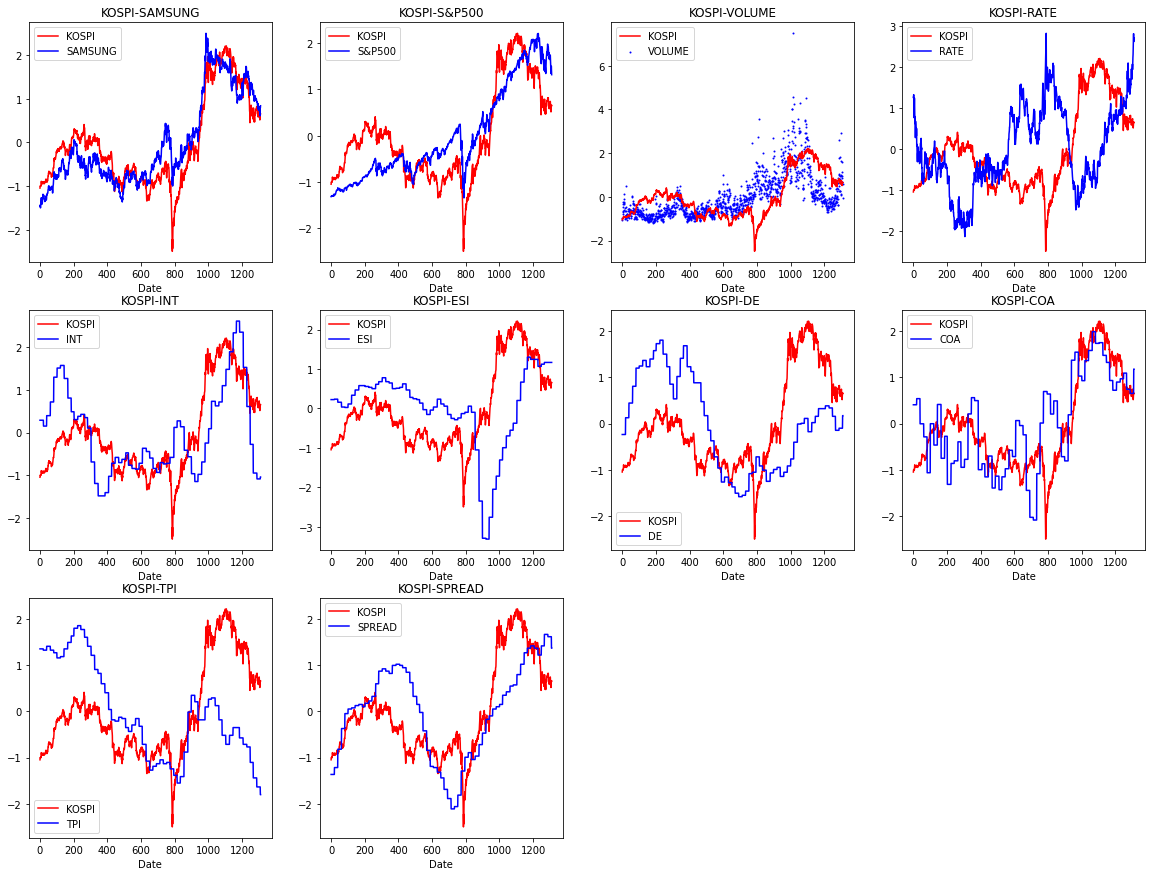

In [24]:
import numpy as np
from scipy import interpolate 
import numpy as np 
import matplotlib.pyplot as plt 
     
plt.figure(figsize=(20,15))
plt.subplot(3, 4,1)                
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")
plt.plot(std_A.index,std_A['SAMSUNG'],label = "SAMSUNG", c='blue')
plt.title('KOSPI-SAMSUNG')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,2)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['SP500'], label = "S&P500", c='blue')
plt.title('KOSPI-S&P500')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,3)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.scatter(std_A.index,std_A['VOLUME'], label = 'VOLUME',c='blue',s=1)
plt.title('KOSPI-VOLUME')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,4)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['RATE'], label = 'RATE', c='blue')
plt.title('KOSPI-RATE')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,5)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['INT'], label = "INT", c='blue')
plt.title('KOSPI-INT')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,6)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red" )# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['ESI'], label = 'ESI', c='blue')
plt.title('KOSPI-ESI')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,7)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['DE'], label = 'DE', c='blue')
plt.title('KOSPI-DE')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,8)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['COA'], label = "COA", c='blue')
plt.title('KOSPI-COA')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,9)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['TPI'], label = 'TPI', c='blue')
plt.title('KOSPI-TPI')
plt.xlabel('Date')
plt.legend()

plt.subplot(3, 4,10)  
plt.plot(std_A['KOSPI'],label = "KOSPI", color="red")# nrows=2, ncols=1, index=2
plt.plot(std_A.index,std_A['SPREAD'], label = "SPREAD", c='blue')
plt.title('KOSPI-SPREAD')
plt.xlabel('Date')
plt.legend()

plt.show()

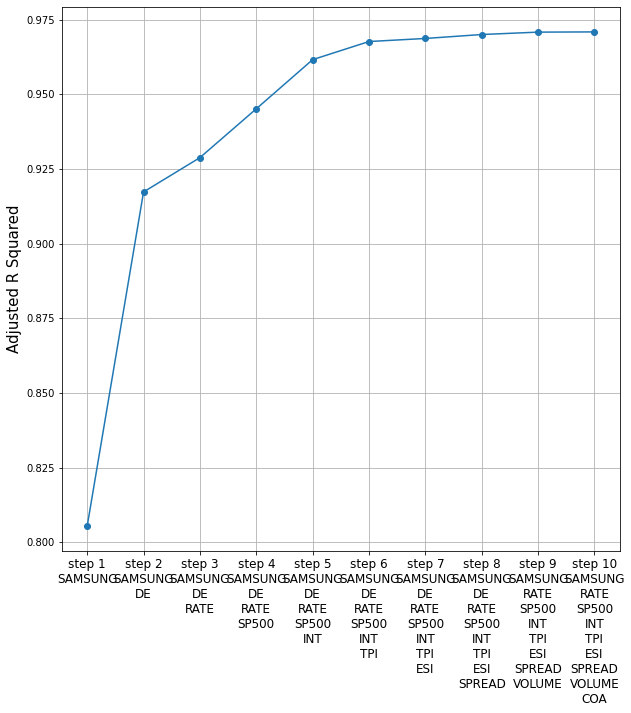

In [25]:
## 단계적 선택법
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
df = std_A
variables = df.columns[1:].tolist() ## 설명 변수 리스트
y = df['KOSPI']
## 전진 단계별 선택법
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
X=X.drop(['const'],axis=1)
fig = plt.figure(figsize=(10,10))

fig.set_facecolor('white')

font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [26]:
res = ols('KOSPI ~ SAMSUNG+SP500+VOLUME+RATE+INT+ESI+COA+TPI+SPREAD', data=std_A).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  KOSPI   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4850.
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        14:40:06   Log-Likelihood:                 461.87
No. Observations:                1311   AIC:                            -903.7
Df Residuals:                    1301   BIC:                            -852.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.179e-16      0.005  -1.73e-13      1.000      -0.009       0.009
SAMSUNG        0.4905      0.016     30.172      0.000       0.459       0.522
SP500          0.4320      0.018     24.523      0.000       0.397       0.467
VOLUME         0.0441      0.008      5.523      0.000       0.028       0.060
RATE          -0.2029      0.009    -23.516      0.000      -0.220      -0.186
INT            0.1131      0.007     16.345      0.000       0.099       0.127
ESI            0.0692      0.007      9.746      0.000       0.055       0.083
COA            0.0156      0.007      2.089      0.037       0.001       0.030
TPI            0.2304      0.010     21.955      0.000       0.210       0.251
SPREAD         0.0647      0.008      7.734      0.000       0.048       0.081
==============================================================================
Omnibus:                       10.551   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.368
Skew:                          -0.069   Prob(JB):                     0.000758
Kurtosis:                       3.494   Cond. No.                         9.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 회귀분석의 기본가정 검정

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fitted = res.predict(std_X)
residual = std_Y- fitted

##### 1. 선형성 : 독립변수와 종속변수 사이에는 선형적인 관계를 띄어야 한다.<br/> 2. 정규성 : 잔차가 평균이 0인 정규분포를 띈다. <br/>3. 등분산성 : 잔차의 분산은 입력변수와 무관하게 일정해야 한다

<AxesSubplot:title={'center':'Homoscedasticity'}>

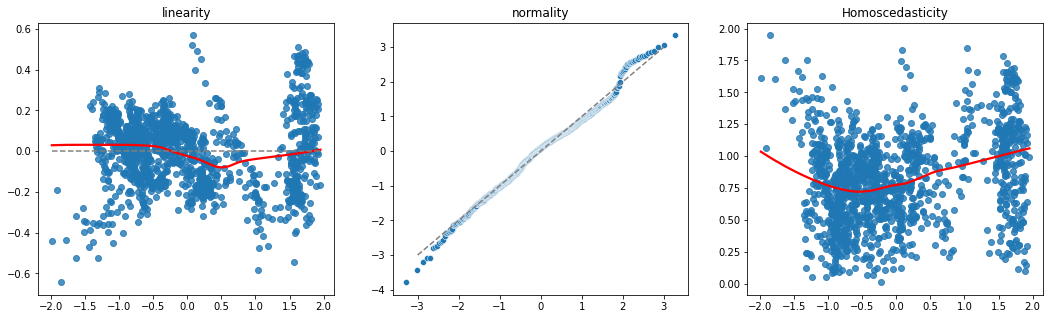

In [28]:
plt.figure(figsize=(18,5))
############선형성###########
plt.subplot(131)
sns.regplot(fitted, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='grey')
plt.title('linearity')
###########정규성#######
import scipy.stats
plt.subplot(132)
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
plt.title('normality')
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')
##########등분산성##########
plt.subplot(133)
plt.title('Homoscedasticity')
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

##### OUTLIER 확인(cook's distance)

In [29]:
from statsmodels.stats.outliers_influence import OLSInfluence
cd, _ = OLSInfluence(res).cooks_distance
cd.sort_values(ascending=False).head()

786     0.022066
1310    0.020217
1307    0.017277
1308    0.015042
1206    0.013259
dtype: float64

# 3.데이터 분석 및 시각화

## PCA 분석으로 차원 축소하기

CA는 기존의 변수를 조합하여 서로 연관성이 없는 새로운 변수, 즉 주성분(principal component, PC)들을 만들어 낸다.

첫 번째 주성분 PC1이 원 데이터의 분포를 가장 많이 보존하고, 두 번째 주성분 PC2가 그 다음으로 원 데이터의 분포를 많이 보존하는 식이다.

앞서 언급한 4차원의 데이터의 경우 기존의 변수들을 조합하여 같은 개수(4개)의 주성분을 만들 수 있는데, 만일 PC1, PC2가 원 데이터의 분포(성질)의 약 90%를 보존한다면,

10% 정도의 정보는 잃어버리더라도, 합리적인 분석에 큰 무리가 없으므로, PC1, PC2 만 택하여 2차원 데이터로 차원을 줄일 수 있다.

이 경우 계산과 시각화가 용이하여 데이터를 쉽게 분석할 수 있다.

<AxesSubplot:>

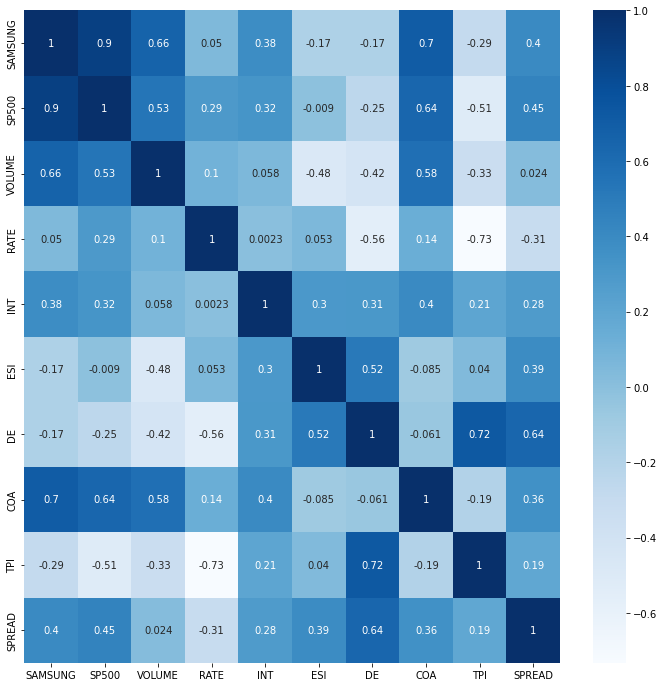

In [30]:
corr = std_X.corr()   # 상관관계 리턴
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,fmt='.2g',cmap='Blues')

In [31]:
print(vif)

   VIF Factor features
0    2.192553      INT
1    2.522012      COA
2    2.908409   VOLUME
3    2.984691      ESI
4    3.409619     RATE
5    6.985101      TPI
6    7.352689   SPREAD
7   11.478003       DE
8   12.526413  SAMSUNG
9   16.991593    SP500


In [32]:
pca_X=std_X[['SAMSUNG','SP500','DE','TPI']]
from sklearn.decomposition import PCA
pca = PCA(n_components=pca_X.shape[1])
pca_array = pca.fit_transform(pca_X)
pca_std_X = pd.DataFrame(pca_array, index=pca_X.index,
                      columns=[f"pca{num+1}" for num in range(pca_X.shape[1])])
pca_std_X

,pca1,pca2,pca3,pca4
0,-2.065739,0.818604,0.778531,-0.440533
1,-2.051970,0.804316,0.787929,-0.424091
2,-2.063565,0.816348,0.780015,-0.437937
3,-2.075179,0.831964,0.761926,-0.476556
4,-2.053360,0.808841,0.778194,-0.447150
...,...,...,...,...
1306,1.947100,-0.064282,-1.039792,-0.048752
1307,1.946720,-0.061470,-1.046941,-0.065988
1308,2.122096,-0.214875,-1.008684,-0.054927
1309,2.039945,-0.269888,-1.279912,0.109053


## PCA 고윳값, 기여율, 누적기여율 확인

      설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca1          2.443731  0.610467  0.610467
pca2          1.219691  0.304690  0.915157
pca3          0.281071  0.070214  0.985371
pca4          0.058561  0.014629  1.000000


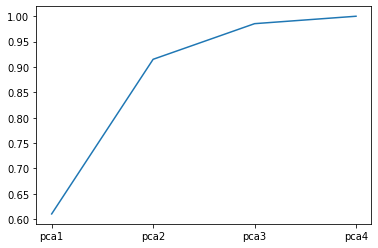

In [33]:
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(pca_X.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()

print(result)
plt.plot(result['누적기여율'])

In [34]:
NOSS=std_X.drop(['SAMSUNG','SP500'],axis=1)

In [35]:
pca_components = pd.DataFrame(pca.components_, index=pca_X.columns,
                      columns=[f"pca{num+1}" for num in range(pca_X.shape[1])])
pca_components

,pca1,pca2,pca3,pca4
SAMSUNG,0.501991,0.564775,-0.411853,-0.509324
SP500,-0.520878,-0.387215,-0.619073,-0.442153
DE,0.342616,-0.181233,-0.645173,0.658423
TPI,0.599420,-0.705867,0.175723,-0.334019


## Biplot으로 PCA 확인

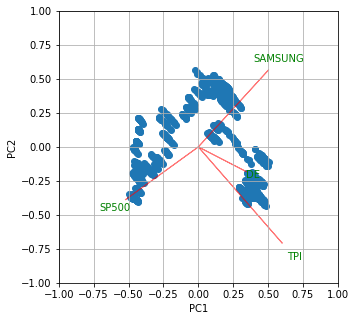

In [36]:
def biplot(score,coeff,pcax,pcay,labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure( figsize = (5, 5))
biplot(pca_array, pca.components_,1, 2, labels=pca_X.columns)

In [37]:
pcass=pca_std_X.iloc[:,:2]
std_pcass= StandardScaler().fit_transform(pcass)
std_pcass= pd.DataFrame(std_pcass, index=pcass.index, columns=pcass.columns)
std_SSX=std_X.drop(['SAMSUNG','SP500','DE','TPI'],axis=1)
std_SSX['std_pca1']=std_pcass['pca1']
std_SSX['std_pca2']=std_pcass['pca2']

In [38]:
std_SSX

,VOLUME,RATE,INT,ESI,COA,SPREAD,std_pca1,std_pca2
0,-1.078234,1.263070,0.290108,0.224381,0.406516,-1.362270,-1.321948,0.741506
1,-0.976785,1.263070,0.290108,0.224381,0.406516,-1.362270,-1.313137,0.728564
2,-0.702647,1.328999,0.290108,0.224381,0.406516,-1.362270,-1.320557,0.739462
3,-0.252161,1.085584,0.290108,0.224381,0.406516,-1.362270,-1.327989,0.753608
4,-0.480229,0.767114,0.290108,0.224381,0.406516,-1.362270,-1.314026,0.732662
...,...,...,...,...,...,...,...,...
1306,1.149983,2.557482,-1.085026,1.166288,0.652087,1.612844,1.246026,-0.058228
1307,0.696897,2.685235,-1.085026,1.166288,0.652087,1.612844,1.245783,-0.055681
1308,0.864600,2.818463,-1.085026,1.166288,0.652087,1.612844,1.358014,-0.194637
1309,0.592849,2.622728,-1.039188,1.166288,1.177186,1.364918,1.305442,-0.244469


<AxesSubplot:>

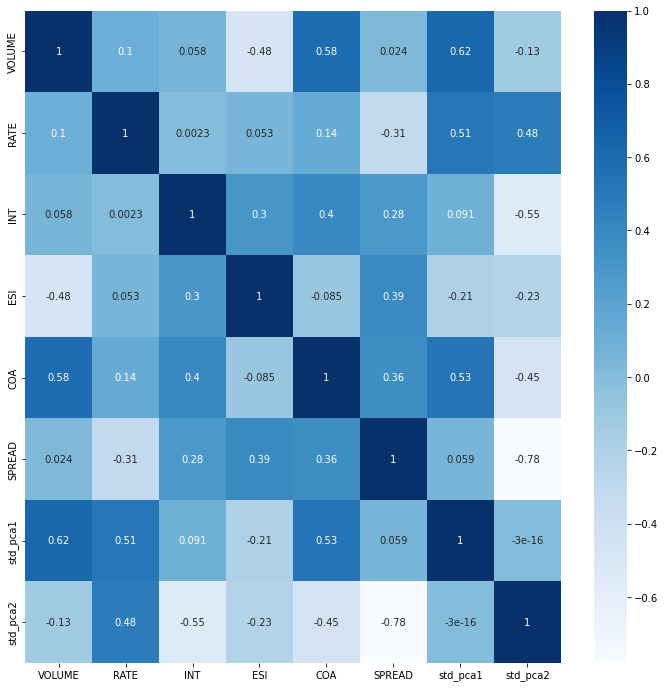

In [39]:
corr = std_SSX.corr()   # 상관관계 리턴
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,fmt='.2g',cmap='Blues')

In [40]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(std_SSX.values, i) for i in range(std_SSX.shape[1])]
vif["features"] = std_SSX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
print(vif)


   VIF Factor  features
0    2.014316       ESI
1    2.136556       INT
2    2.464249       COA
3    2.681153    VOLUME
4    2.684440      RATE
5    2.749006  std_pca1
6    3.746622    SPREAD
7    5.953368  std_pca2


# 4. 각 모델별 성능비교


In [41]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(std_SSX, std_Y,test_size=0.2, random_state=0,shuffle=False)

In [43]:
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_train=linear.predict(X_train)
linear_test=linear.predict(X_test)
y1=pd.DataFrame(linear_train)
y2=pd.DataFrame(linear_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
linear_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha =10)
ridge.fit(X_train, y_train)
ridge_train=ridge.predict(X_train)
ridge_test=ridge.predict(X_test)
y1=pd.DataFrame(ridge_train)
y2=pd.DataFrame(ridge_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
ridge_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
lasso_train = lasso.predict(X_train)
lasso_test = lasso.predict(X_test)
y1=pd.DataFrame(lasso_train)
y2=pd.DataFrame(lasso_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
lasso_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.1, l1_ratio=0.3, normalize=False) #normalize=False
elastic.fit(X_train, y_train)
elastic_train = elastic.predict(X_train)
elastic_test = elastic.predict(X_test)
y1=pd.DataFrame(elastic_train)
y2=pd.DataFrame(elastic_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
elastic_pred = y3.sort_index(ascending=True)

from sklearn.tree import DecisionTreeRegressor
decisiontree=DecisionTreeRegressor(random_state=0,max_depth=5)
decisiontree.fit(X_train, y_train)
decisiontree_train = decisiontree.predict(X_train)
decisiontree_test = decisiontree.predict(X_test)
y1=pd.DataFrame(decisiontree_train)
y2=pd.DataFrame(decisiontree_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
decisiontree_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(n_estimators=2000,
                        max_depth=5, max_features=6,
                        oob_score=False, random_state=0)
randomforest.fit(X_train, y_train)
randomforest_train = randomforest.predict(X_train)
randomforest_test = randomforest.predict(X_test)
y1=pd.DataFrame(randomforest_train)
y2=pd.DataFrame(randomforest_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
randomforest_pred = y3.sort_index(ascending=True)

import xgboost
Xgboost = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.87,max_depth=5,random_state=0)# gamma=0, subsample=0.75,colsample_bytree=1)
Xgboost.fit(X_train, y_train)
Xgboost_train = Xgboost.predict(X_train)
Xgboost_test = Xgboost.predict(X_test)
y1=pd.DataFrame(Xgboost_train)
y2=pd.DataFrame(Xgboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
Xgboost_pred = y3.sort_index(ascending=True)

from catboost import CatBoostRegressor
catboost = CatBoostRegressor(n_estimators=1000, learning_rate=0.16,max_depth=4,verbose=False)
catboost.fit(X_train, y_train)
catboost_train=catboost.predict(X_train)
catboost_test=catboost.predict(X_test)
y1=pd.DataFrame(catboost_train)
y2=pd.DataFrame(catboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
catboost_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import GradientBoostingRegressor
gradientboost=GradientBoostingRegressor(random_state=0,n_estimators=1000,learning_rate=0.13,max_depth=4)
gradientboost.fit(X_train, y_train)
gradientboost_train = gradientboost.predict(X_train)
gradientboost_test = gradientboost.predict(X_test)
y1=pd.DataFrame(gradientboost_train)
y2=pd.DataFrame(gradientboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
gradientboost_pred = y3.sort_index(ascending=True)

method=['Linear','Ridge','Lasso','Elasticnet','DecisionTree','RandomForest','Xgboost','Catboost','Gradientboost']

r2train=[r2_score(y_train,linear_train),
         r2_score(y_train,ridge_train),
         r2_score(y_train,lasso_train),
         r2_score(y_train,elastic_train),
         r2_score(y_train,decisiontree_train),
         r2_score(y_train,randomforest_train),
         r2_score(y_train,Xgboost_train),
         r2_score(y_train,catboost_train),
         r2_score(y_train,gradientboost_train)]

r2test=[r2_score(y_test,linear_test),
        r2_score(y_test,ridge_test),
        r2_score(y_test,lasso_test),
        r2_score(y_test,elastic_test),
        r2_score(y_test,decisiontree_test),
        r2_score(y_test,randomforest_test),
        r2_score(y_test,Xgboost_test),
        r2_score(y_test,catboost_test),
        r2_score(y_test,gradientboost_test)]

rmse=[mean_squared_error(y_test,linear_test)**0.5,
      mean_squared_error(y_test,ridge_test)**0.5,
      mean_squared_error(y_test,lasso_test)**0.5,
      mean_squared_error(y_test,elastic_test)**0.5,
      mean_squared_error(y_test,decisiontree_test)**0.5,
      mean_squared_error(y_test,randomforest_test)**0.5,
      mean_squared_error(y_test,Xgboost_test)**0.5,
      mean_squared_error(y_test,catboost_test)**0.5,
      mean_squared_error(y_test,gradientboost_test)**0.5]

y_pred=[linear_pred,
        ridge_pred,
        lasso_pred,
        elastic_pred,
        decisiontree_pred,
        randomforest_pred,
        Xgboost_pred,
        catboost_pred,
        gradientboost_pred]

In [44]:
final=pd.DataFrame(zip(r2train,r2test,rmse),index=method,columns=['r2train','r2test','rmse'])
final.style.highlight_max(axis=0,color='red')


,r2train,r2test,rmse
Linear,0.947187,0.678383,0.299654
Ridge,0.946490,0.572137,0.345623
Lasso,0.000000,-11.830580,1.892664
Elasticnet,0.901461,-1.468079,0.830099
DecisionTree,0.968115,-0.611408,0.670738
RandomForest,0.980261,0.228394,0.464139
Xgboost,0.999998,-0.092244,0.552218
Catboost,0.999442,-0.357138,0.615549
Gradientboost,0.999991,-0.012451,0.531664


In [45]:
final.style.highlight_min(axis=0,color='blue')

,r2train,r2test,rmse
Linear,0.947187,0.678383,0.299654
Ridge,0.946490,0.572137,0.345623
Lasso,0.000000,-11.830580,1.892664
Elasticnet,0.901461,-1.468079,0.830099
DecisionTree,0.968115,-0.611408,0.670738
RandomForest,0.980261,0.228394,0.464139
Xgboost,0.999998,-0.092244,0.552218
Catboost,0.999442,-0.357138,0.615549
Gradientboost,0.999991,-0.012451,0.531664


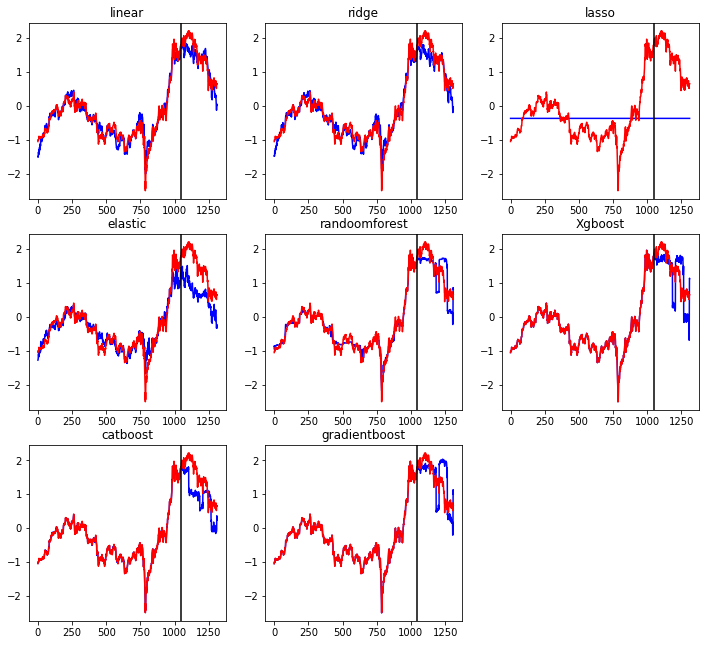

In [46]:
plt.figure( figsize = (12, 11))

plt.subplot(331)
plt.plot(linear_pred,'b')
plt.plot(std_Y,'r')
plt.title('linear')
plt.axvline(x=1048,color='black')

plt.subplot(332)
plt.plot(ridge_pred,'b')
plt.plot(std_Y,'r')
plt.title('ridge')
plt.axvline(x=1048,color='black')

plt.subplot(333)
plt.plot(lasso_pred,'b')
plt.plot(std_Y,'r')
plt.title('lasso')
plt.axvline(x=1048,color='black')

plt.subplot(334)
plt.plot(elastic_pred,'b')
plt.plot(std_Y,'r')
plt.title('elastic')
plt.axvline(x=1048,color='black')

plt.subplot(335)
plt.plot(randomforest_pred,'b')
plt.plot(std_Y,'r')
plt.title('randoomforest')
plt.axvline(x=1048,color='black')

plt.subplot(336)
plt.plot(Xgboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('Xgboost')
plt.axvline(x=1048,color='black')

plt.subplot(337)
plt.plot(catboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('catboost')
plt.axvline(x=1048,color='black')

plt.subplot(338)
plt.plot(gradientboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('gradientboost')
plt.axvline(x=1048,color='black')


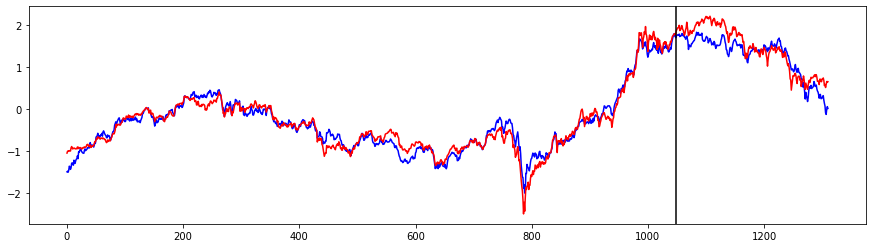

In [47]:
plt.figure( figsize = (15, 4))
plt.plot(linear_pred,'b')
plt.plot(std_Y,'r')
plt.axvline(x=1048,color='black')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(std_SSX,std_Y,test_size=0.2, random_state=0,shuffle=True)

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_train=linear.predict(X_train)
linear_test=linear.predict(X_test)
y1=pd.DataFrame(linear_train)
y2=pd.DataFrame(linear_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
linear_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha =10)
ridge.fit(X_train, y_train)
ridge_train=ridge.predict(X_train)
ridge_test=ridge.predict(X_test)
y1=pd.DataFrame(ridge_train)
y2=pd.DataFrame(ridge_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
ridge_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
lasso_train = lasso.predict(X_train)
lasso_test = lasso.predict(X_test)
y1=pd.DataFrame(lasso_train)
y2=pd.DataFrame(lasso_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
lasso_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.1, l1_ratio=0.3, normalize=False) #normalize=False
elastic.fit(X_train, y_train)
elastic_train = elastic.predict(X_train)
elastic_test = elastic.predict(X_test)
y1=pd.DataFrame(elastic_train)
y2=pd.DataFrame(elastic_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
elastic_pred = y3.sort_index(ascending=True)

from sklearn.tree import DecisionTreeRegressor
decisiontree=DecisionTreeRegressor(random_state=0,max_depth=5)
decisiontree.fit(X_train, y_train)
decisiontree_train = decisiontree.predict(X_train)
decisiontree_test = decisiontree.predict(X_test)
y1=pd.DataFrame(decisiontree_train)
y2=pd.DataFrame(decisiontree_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
decisiontree_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(n_estimators=2000,
                        max_depth=5, max_features=6,
                        oob_score=False, random_state=0)
randomforest.fit(X_train, y_train)
randomforest_train = randomforest.predict(X_train)
randomforest_test = randomforest.predict(X_test)
y1=pd.DataFrame(randomforest_train)
y2=pd.DataFrame(randomforest_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
randomforest_pred = y3.sort_index(ascending=True)

import xgboost
Xgboost = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.87,max_depth=5,random_state=0)# gamma=0, subsample=0.75,colsample_bytree=1)
Xgboost.fit(X_train, y_train)
Xgboost_train = Xgboost.predict(X_train)
Xgboost_test = Xgboost.predict(X_test)
y1=pd.DataFrame(Xgboost_train)
y2=pd.DataFrame(Xgboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
Xgboost_pred = y3.sort_index(ascending=True)

from catboost import CatBoostRegressor
catboost = CatBoostRegressor(n_estimators=1000, learning_rate=0.16,max_depth=4,verbose=False)
catboost.fit(X_train, y_train)
catboost_train=catboost.predict(X_train)
catboost_test=catboost.predict(X_test)
y1=pd.DataFrame(catboost_train)
y2=pd.DataFrame(catboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
catboost_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import GradientBoostingRegressor
gradientboost=GradientBoostingRegressor(random_state=0,n_estimators=1000,learning_rate=0.13,max_depth=4)
gradientboost.fit(X_train, y_train)
gradientboost_train = gradientboost.predict(X_train)
gradientboost_test = gradientboost.predict(X_test)
y1=pd.DataFrame(gradientboost_train)
y2=pd.DataFrame(gradientboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
gradientboost_pred = y3.sort_index(ascending=True)

method=['Linear','Ridge','Lasso','Elasticnet','DecisionTree','RandomForest','Xgboost','Catboost','Gradientboost']

r2train=[r2_score(y_train,linear_train),
         r2_score(y_train,ridge_train),
         r2_score(y_train,lasso_train),
         r2_score(y_train,elastic_train),
         r2_score(y_train,decisiontree_train),
         r2_score(y_train,randomforest_train),
         r2_score(y_train,Xgboost_train),
         r2_score(y_train,catboost_train),
         r2_score(y_train,gradientboost_train)]

r2test=[r2_score(y_test,linear_test),
        r2_score(y_test,ridge_test),
        r2_score(y_test,lasso_test),
        r2_score(y_test,elastic_test),
        r2_score(y_test,decisiontree_test),
        r2_score(y_test,randomforest_test),
        r2_score(y_test,Xgboost_test),
        r2_score(y_test,catboost_test),
        r2_score(y_test,gradientboost_test)]

rmse=[mean_squared_error(y_test,linear_test)**0.5,
      mean_squared_error(y_test,ridge_test)**0.5,
      mean_squared_error(y_test,lasso_test)**0.5,
      mean_squared_error(y_test,elastic_test)**0.5,
      mean_squared_error(y_test,decisiontree_test)**0.5,
      mean_squared_error(y_test,randomforest_test)**0.5,
      mean_squared_error(y_test,Xgboost_test)**0.5,
      mean_squared_error(y_test,catboost_test)**0.5,
      mean_squared_error(y_test,gradientboost_test)**0.5]

y_pred=[linear_pred,
        ridge_pred,
        lasso_pred,
        elastic_pred,
        decisiontree_pred,
        randomforest_pred,
        Xgboost_pred,
        catboost_pred,
        gradientboost_pred]

In [49]:
final=pd.DataFrame(zip(r2train,r2test,rmse),index=method,columns=['r2train','r2test','rmse'])
final.style.highlight_max(axis=0,color='red')

,r2train,r2test,rmse
Linear,0.966175,0.961101,0.204882
Ridge,0.965934,0.960524,0.206397
Lasso,0.000000,-0.000099,1.038858
Elasticnet,0.951233,0.943636,0.246625
DecisionTree,0.983043,0.972059,0.173641
RandomForest,0.989710,0.986059,0.122654
Xgboost,0.999999,0.990388,0.101844
Catboost,0.999631,0.996147,0.064477
Gradientboost,0.999994,0.994546,0.076717


In [50]:
final.style.highlight_min(axis=0,color='blue')

,r2train,r2test,rmse
Linear,0.966175,0.961101,0.204882
Ridge,0.965934,0.960524,0.206397
Lasso,0.000000,-0.000099,1.038858
Elasticnet,0.951233,0.943636,0.246625
DecisionTree,0.983043,0.972059,0.173641
RandomForest,0.989710,0.986059,0.122654
Xgboost,0.999999,0.990388,0.101844
Catboost,0.999631,0.996147,0.064477
Gradientboost,0.999994,0.994546,0.076717


Text(0.5, 1.0, 'gradientboost')

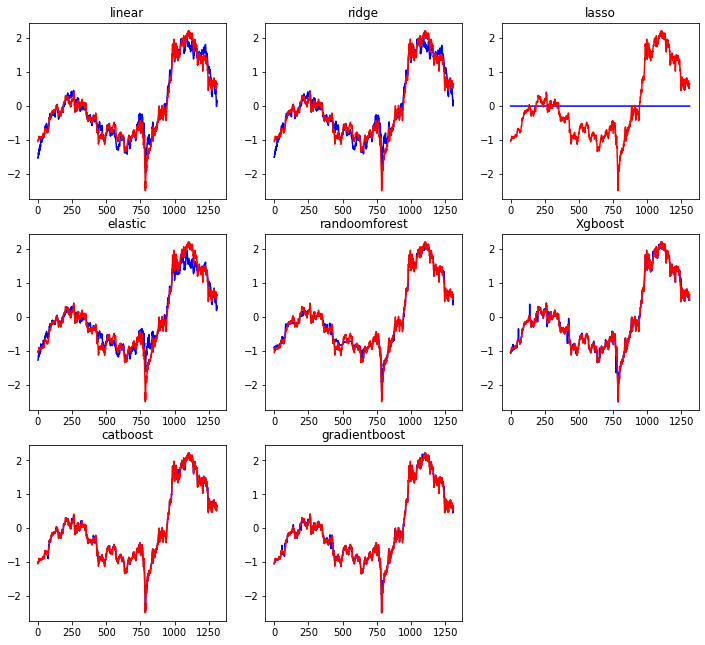

In [51]:
plt.figure( figsize = (12, 11))

plt.subplot(331)
plt.plot(linear_pred,'b')
plt.plot(std_Y,'r')
plt.title('linear')

plt.subplot(332)
plt.plot(ridge_pred,'b')
plt.plot(std_Y,'r')
plt.title('ridge')

plt.subplot(333)
plt.plot(lasso_pred,'b')
plt.plot(std_Y,'r')
plt.title('lasso')

plt.subplot(334)
plt.plot(elastic_pred,'b')
plt.plot(std_Y,'r')
plt.title('elastic')

plt.subplot(335)
plt.plot(randomforest_pred,'b')
plt.plot(std_Y,'r')
plt.title('randoomforest')

plt.subplot(336)
plt.plot(Xgboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('Xgboost')

plt.subplot(337)
plt.plot(catboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('catboost')

plt.subplot(338)
plt.plot(gradientboost_pred,'b')
plt.plot(std_Y,'r')
plt.title('gradientboost')


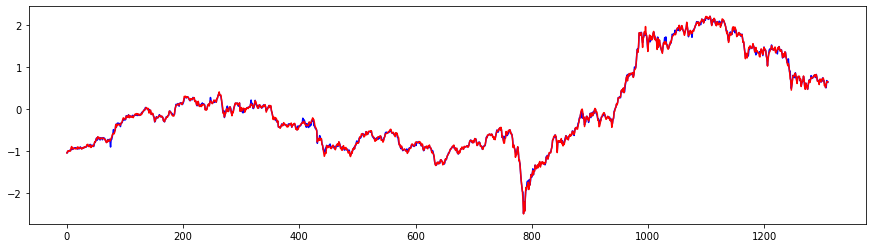

In [52]:
plt.figure( figsize = (15, 4))
plt.plot(catboost_pred,'b')
plt.plot(std_Y,'r')

In [53]:
X=pd.read_csv('./data1.csv')
std_X = StandardScaler().fit_transform(X)
std_X = pd.DataFrame(std_X, index=X.index, columns=X.columns)
pca_X=std_X[['SAMSUNG','SP500','DE','TPI']]
from sklearn.decomposition import PCA
pca = PCA(n_components=pca_X.shape[1])
pca_array = pca.fit_transform(pca_X)
pca_std_X = pd.DataFrame(pca_array, index=pca_X.index,
                      columns=[f"pca{num+1}" for num in range(pca_X.shape[1])])
pca_std_X
pca_std_X = pd.DataFrame(pca_array, index=pca_X.index,
                      columns=[f"pca{num+1}" for num in range(pca_X.shape[1])])
pcass=pca_std_X.iloc[:,:2]
std_pcass= StandardScaler().fit_transform(pcass)
std_pcass= pd.DataFrame(std_pcass, index=pcass.index, columns=pcass.columns)
std_SSX=std_X.drop(['SAMSUNG','SP500','DE','TPI'],axis=1)
std_SSX['std_pca1']=std_pcass['pca1']
std_SSX['std_pca2']=std_pcass['pca2']

In [54]:
aafd=y_train.index
aafd.sort_values()

Int64Index([   0,    2,    3,    4,    6,    7,   10,   11,   12,   13,
            ...
            1295, 1296, 1297, 1298, 1299, 1300, 1303, 1305, 1306, 1309],
           dtype='int64', length=1048)

In [55]:
myrobo=std_SSX.iloc[-1]
from datetime import date 
today = date.today()
mydate=today.strftime('%Y년 %m월 %d일')
print("마이러버(MY ROBO)의 {} 코스피 마감지수 예측값은 {} 입니다.".format(mydate,round(np.std(Y)*catboost.predict(myrobo)+np.mean(Y),3)))

마이러버(MY ROBO)의 2022년 05월 04일 코스피 마감지수 예측값은 2687.177 입니다.


In [56]:
COEF = pd.read_csv('COEF.csv',index_col=0)
COEF

,COA,std_PCA1,std_PCA2,INT,ESI,SPREAD,RATE,VOLUME
linear_coef,-0.101129,-0.074373,0.003281,-0.121819,0.008565,-0.044301,-0.068720,-0.047256
ridge_coef,-0.096130,-0.072310,0.003356,-0.119638,0.007530,-0.042363,-0.064874,-0.045476
lasso_coef,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
elastic_coef,0.000000,-0.025281,0.000000,-0.062174,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'GradientBoost')

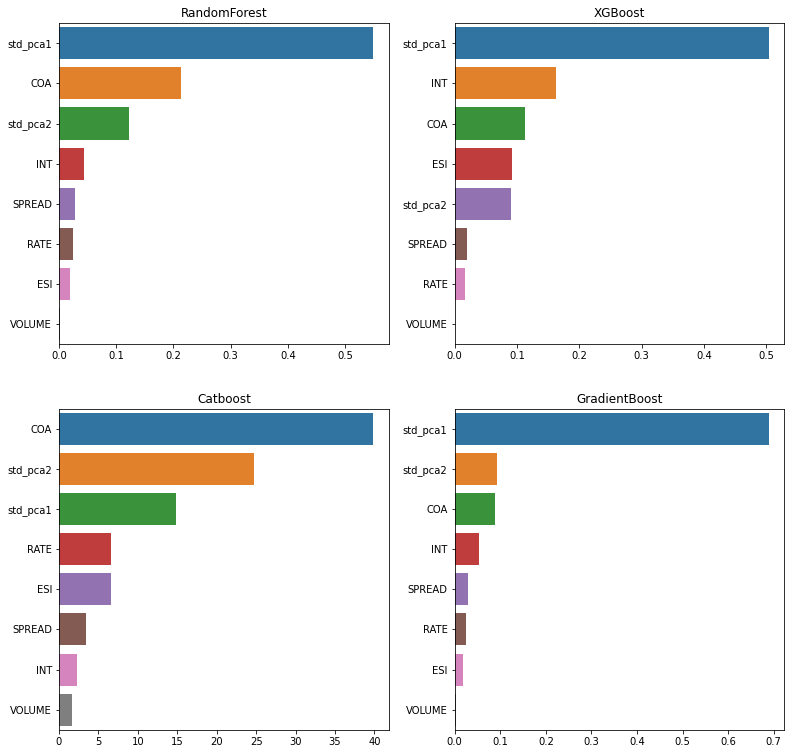

In [57]:
plt.figure( figsize = (13, 13))

plt.subplot(221)
feature_series=pd.Series(data=randomforest.feature_importances_,index=std_SSX.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('RandomForest')

plt.subplot(222)
feature_series=pd.Series(data=Xgboost.feature_importances_,index=std_SSX.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('XGBoost')

plt.subplot(223)
feature_series=pd.Series(data=catboost.feature_importances_,index=std_SSX.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('Catboost')

plt.subplot(224)
feature_series=pd.Series(data=gradientboost.feature_importances_,index=std_SSX.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('GradientBoost')

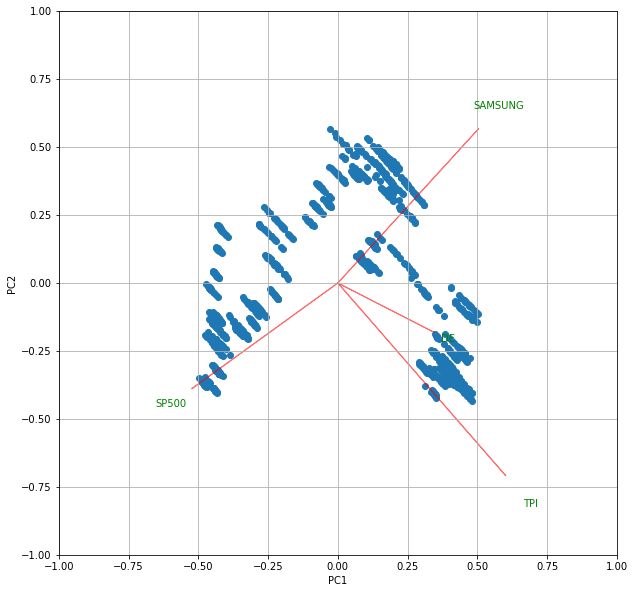

In [58]:
plt.figure( figsize = (10, 10))
biplot(pca_array, pca.components_,1, 2, labels=pca_X.columns)

 INT : 재고순환지수 (경제의 재고순환과정 측정지표) <br/>

 ESI : 경제심리지수 (기업과 소비자의 경제전망 심리지표)<br/>

 DE : 기계류 내수출하지수 (기업의 설비투자 지표)<br/>

 COA : 건설수주액 (국내 건설경기의 대표지수)<br/>

 TPI : 수출입물가비율 (수출입상품의 가격동향)<br/>

 SPREAD : 장단기금리차(5년 국고채 유통 수익률 월평균 금리 - 1일물 무담보콜금리의 월평균 금리)<br/>

In [59]:
pca_components = pd.DataFrame(pca.components_, index=pca_X.columns,
                      columns=[f"pca{num+1}" for num in range(pca_X.shape[1])])
pca_components

,pca1,pca2,pca3,pca4
SAMSUNG,0.502208,0.564964,-0.411286,-0.509359
SP500,-0.520532,-0.386831,-0.619897,-0.441742
DE,0.342859,-0.180264,-0.644899,0.658831
TPI,0.599401,-0.706175,0.175149,-0.333705


# 5.결과<br/>  건설수주액, 수출입 물가비율..?

## 프로젝트의 한계점, 느낀점, 의의

[한계점]
- 데이터의 전처리가 완벽했는가? <br/>

- 최선의 모델 학습과 선택이 이루어졌는가? <br/>

- 경기선행지수의 요소들은 지속적인 개편이 이루어지므로, 꾸준한 모델 업데이트가 필요<br/>

- 이상치 제거를 하려했으나, 실제 경제상황을 반영하기 위해 그대로 유지<br/>

- PCA를 통해 성능향상을 도모하였으나, 명확한 중요변수 파악이 어려웠음<br/>

- 코드를 간단하게 작성하고 싶었으나 시간적여유와 부족한 코딩실력으로 확인하고 또 확인하는 시행착오가 매우 많았음<br/>

[느낀점]
- 장기 프로젝트는 초반 기획과 계획 수립이 매우 중요함..<br/>

- 프로젝트가 진행되면서 주제와 진행과정에 변화는 필수적임. -> 변경점을 매번 명확히 정리하지 못하여 혼란을 겪기도 함<br/>

- 효율적인 역할분담의 어려움을 겪음. <br/>

[의의]
- 파이썬을 활용하여 데이터를 직접 수집함<br/>

- 데이터 전처리 과정을 실습함(결측치 처리, 날짜 맞추기, 단위 수정 등)<br/>

- 다양한 회귀모델학습 (각 모델별 특징과 장단점)<br/>

- 통계적 검정 과정을 학습함 <br/>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(NOSS,std_Y,test_size=0.2, random_state=0,shuffle=True)

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_train=linear.predict(X_train)
linear_test=linear.predict(X_test)
y1=pd.DataFrame(linear_train)
y2=pd.DataFrame(linear_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
linear_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha =10)
ridge.fit(X_train, y_train)
ridge_train=ridge.predict(X_train)
ridge_test=ridge.predict(X_test)
y1=pd.DataFrame(ridge_train)
y2=pd.DataFrame(ridge_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
ridge_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
lasso_train = lasso.predict(X_train)
lasso_test = lasso.predict(X_test)
y1=pd.DataFrame(lasso_train)
y2=pd.DataFrame(lasso_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
lasso_pred = y3.sort_index(ascending=True)

from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.1, l1_ratio=0.3, normalize=False) #normalize=False
elastic.fit(X_train, y_train)
elastic_train = elastic.predict(X_train)
elastic_test = elastic.predict(X_test)
y1=pd.DataFrame(elastic_train)
y2=pd.DataFrame(elastic_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
elastic_pred = y3.sort_index(ascending=True)

from sklearn.tree import DecisionTreeRegressor
decisiontree=DecisionTreeRegressor(random_state=0,max_depth=5)
decisiontree.fit(X_train, y_train)
decisiontree_train = decisiontree.predict(X_train)
decisiontree_test = decisiontree.predict(X_test)
y1=pd.DataFrame(decisiontree_train)
y2=pd.DataFrame(decisiontree_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
decisiontree_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(n_estimators=2000,
                        max_depth=5, max_features=6,
                        oob_score=False, random_state=0)
randomforest.fit(X_train, y_train)
randomforest_train = randomforest.predict(X_train)
randomforest_test = randomforest.predict(X_test)
y1=pd.DataFrame(randomforest_train)
y2=pd.DataFrame(randomforest_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
randomforest_pred = y3.sort_index(ascending=True)

import xgboost
Xgboost = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.87,max_depth=5,random_state=0)# gamma=0, subsample=0.75,colsample_bytree=1)
Xgboost.fit(X_train, y_train)
Xgboost_train = Xgboost.predict(X_train)
Xgboost_test = Xgboost.predict(X_test)
y1=pd.DataFrame(Xgboost_train)
y2=pd.DataFrame(Xgboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
Xgboost_pred = y3.sort_index(ascending=True)

from catboost import CatBoostRegressor
catboost = CatBoostRegressor(n_estimators=1000, learning_rate=0.16,max_depth=4,verbose=False)
catboost.fit(X_train, y_train)
catboost_train=catboost.predict(X_train)
catboost_test=catboost.predict(X_test)
y1=pd.DataFrame(catboost_train)
y2=pd.DataFrame(catboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
catboost_pred = y3.sort_index(ascending=True)

from sklearn.ensemble import GradientBoostingRegressor
gradientboost=GradientBoostingRegressor(random_state=0,n_estimators=1000,learning_rate=0.13,max_depth=4)
gradientboost.fit(X_train, y_train)
gradientboost_train = gradientboost.predict(X_train)
gradientboost_test = gradientboost.predict(X_test)
y1=pd.DataFrame(gradientboost_train)
y2=pd.DataFrame(gradientboost_test)
y1.index=y_train.index
y2.index=y_test.index
y3=pd.concat([y1,y2])
gradientboost_pred = y3.sort_index(ascending=True)

method=['Linear','Ridge','Lasso','Elasticnet','DecisionTree','RandomForest','Xgboost','Catboost','Gradientboost']

r2train=[r2_score(y_train,linear_train),
         r2_score(y_train,ridge_train),
         r2_score(y_train,lasso_train),
         r2_score(y_train,elastic_train),
         r2_score(y_train,decisiontree_train),
         r2_score(y_train,randomforest_train),
         r2_score(y_train,Xgboost_train),
         r2_score(y_train,catboost_train),
         r2_score(y_train,gradientboost_train)]

r2test=[r2_score(y_test,linear_test),
        r2_score(y_test,ridge_test),
        r2_score(y_test,lasso_test),
        r2_score(y_test,elastic_test),
        r2_score(y_test,decisiontree_test),
        r2_score(y_test,randomforest_test),
        r2_score(y_test,Xgboost_test),
        r2_score(y_test,catboost_test),
        r2_score(y_test,gradientboost_test)]

rmse=[mean_squared_error(y_test,linear_test)**0.5,
      mean_squared_error(y_test,ridge_test)**0.5,
      mean_squared_error(y_test,lasso_test)**0.5,
      mean_squared_error(y_test,elastic_test)**0.5,
      mean_squared_error(y_test,decisiontree_test)**0.5,
      mean_squared_error(y_test,randomforest_test)**0.5,
      mean_squared_error(y_test,Xgboost_test)**0.5,
      mean_squared_error(y_test,catboost_test)**0.5,
      mean_squared_error(y_test,gradientboost_test)**0.5]

y_pred=[linear_pred,
        ridge_pred,
        lasso_pred,
        elastic_pred,
        decisiontree_pred,
        randomforest_pred,
        Xgboost_pred,
        catboost_pred,
        gradientboost_pred]

Text(0.5, 1.0, 'GradientBoost')

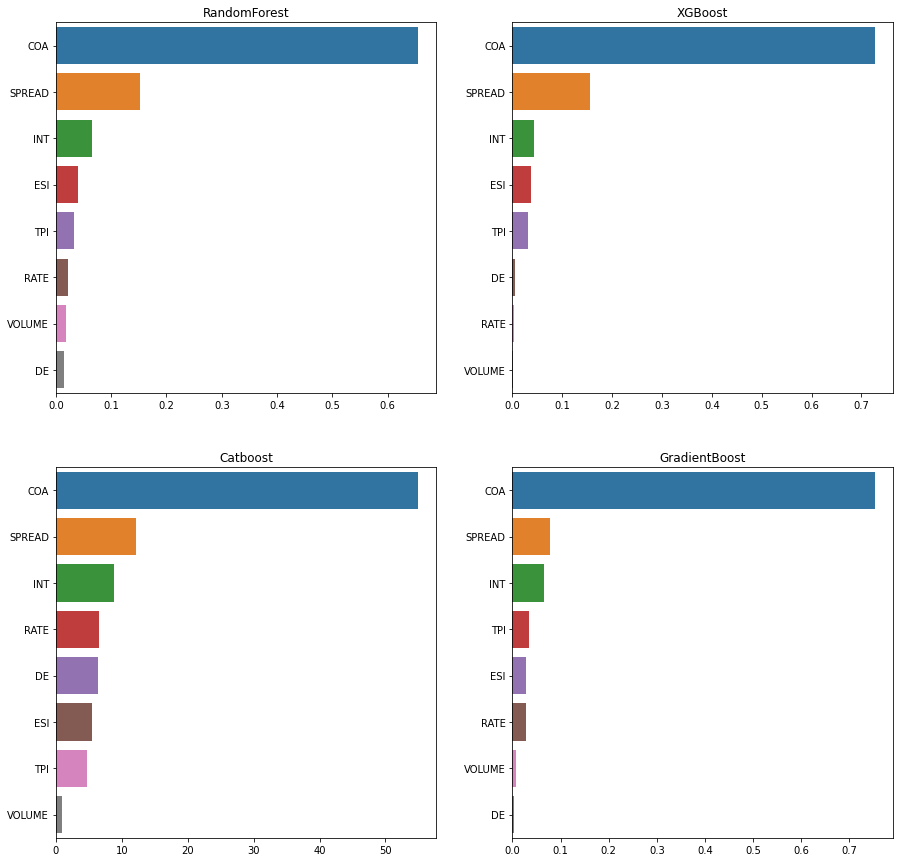

In [61]:
plt.figure( figsize = (15, 15))

plt.subplot(221)
feature_series=pd.Series(data=randomforest.feature_importances_,index=NOSS.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('RandomForest')

plt.subplot(222)
feature_series=pd.Series(data=Xgboost.feature_importances_,index=NOSS.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('XGBoost')

plt.subplot(223)
feature_series=pd.Series(data=catboost.feature_importances_,index=NOSS.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('Catboost')

plt.subplot(224)
feature_series=pd.Series(data=gradientboost.feature_importances_,index=NOSS.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series,y=feature_series.index)
plt.title('GradientBoost')

In [62]:
# import statsmodels.graphics.tsaplots as sgt 

# ## Close
# fig = plt.figure(figsize=(15,10))
# ax1 = fig.add_subplot(2, 1, 1)
# ax2 = fig.add_subplot(2, 1, 2)

# sgt.plot_acf(A['KOSPI'], lags = 20, zero = False, ax=ax1)
# ax1.set_title("kospi")

# sgt.plot_pacf(A['KOSPI'], lags = 20, zero = False, method = ('ols'), ax=ax2)
# ax2.set_title("kospi")

# plt.show()

In [63]:
# diff_1=A['KOSPI'].diff(periods=1)
# diff_1.iloc[0]=0
# diff_1
# diff_1.plot()
# fig = plt.figure()

# import statsmodels.api as sm
# sm.graphics.tsa.plot_acf(pd.Series(std_A['KOSPI']), lags=50, use_vlines=True)
# # sgt.plot_pacf(diff_1, lags = 20, zero = False, method = ('ols'), ax=ax2)
# # ax2.set_title("diff")
# sm.graphics.tsa.plot_pacf(pd.Series(std_A['KOSPI']), lags=50, use_vlines=True)
# plt.show()

In [64]:
# import statsmodels.api as sm
# sm.graphics.tsa.plot_acf(pd.Series(diff_1), lags=50, use_vlines=True)
# sm.graphics.tsa.plot_pacf(pd.Series(diff_1), lags=50, use_vlines=True)

In [65]:
# plt.subplot(211)
# diff_1.plot()
# plt.subplot(212)
# A['KOSPI'].plot()

In [66]:
# diff_1=pd.DataFrame(diff_1)
# std_diff_1 = StandardScaler().fit_transform(diff_1)
# std_diff_1=pd.DataFrame(std_diff_1)
# sm.stats.acorr_ljungbox(diff_1, lags=[5], return_df=True)
# # acorr_ljungbox(x, lags=None)

In [67]:
# from pmdarima.arima import ndiffs
# kpss_diffs = ndiffs(A['KOSPI'], alpha=0.05 , test='kpss', max_d = 6)
# adf_diffs = ndiffs(A['KOSPI'], alpha=0.05 , test='adf', max_d = 6)
# n_diffs = max(adf_diffs,kpss_diffs)

# print(f'적정 차분 차수는 {n_diffs}')

In [68]:
# UDF for KPSS test 
from statsmodels.tsa.stattools import kpss 
import pandas as pd 
def kpss_test(timeseries): 
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series( 
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
         ) 
    for key, value in kpsstest[3].items(): 
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

print(kpss_test(A['KOSPI']))    
print(kpss_test(diff_1))

Results of KPSS Test:
Test Statistic            2.561141
p-value                   0.010000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


NameError: name 'diff_1' is not defined

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(std_SSX, std_diff_1,test_size=0.2, random_state=0,shuffle=True)

# import warnings
# warnings.filterwarnings(action='ignore')

# from sklearn.linear_model import LinearRegression
# linear = LinearRegression()
# linear.fit(X_train, y_train)
# linear_train=linear.predict(X_train)
# linear_test=linear.predict(X_test)
# y1=pd.DataFrame(linear_train)
# y2=pd.DataFrame(linear_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# linear_pred = y3.sort_index(ascending=True)

# from sklearn.linear_model import Ridge
# ridge = Ridge(alpha =10)
# ridge.fit(X_train, y_train)
# ridge_train=ridge.predict(X_train)
# ridge_test=ridge.predict(X_test)
# y1=pd.DataFrame(ridge_train)
# y2=pd.DataFrame(ridge_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# ridge_pred = y3.sort_index(ascending=True)

# from sklearn.linear_model import Lasso
# lasso = Lasso(alpha=1)
# lasso.fit(X_train, y_train)
# lasso_train = lasso.predict(X_train)
# lasso_test = lasso.predict(X_test)
# y1=pd.DataFrame(lasso_train)
# y2=pd.DataFrame(lasso_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# lasso_pred = y3.sort_index(ascending=True)

# from sklearn.linear_model import ElasticNet
# elastic = ElasticNet(alpha=0.1, l1_ratio=0.3, normalize=False) #normalize=False
# elastic.fit(X_train, y_train)
# elastic_train = elastic.predict(X_train)
# elastic_test = elastic.predict(X_test)
# y1=pd.DataFrame(elastic_train)
# y2=pd.DataFrame(elastic_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# elastic_pred = y3.sort_index(ascending=True)

# from sklearn.tree import DecisionTreeRegressor
# decisiontree=DecisionTreeRegressor(random_state=0,max_depth=5)
# decisiontree.fit(X_train, y_train)
# decisiontree_train = decisiontree.predict(X_train)
# decisiontree_test = decisiontree.predict(X_test)
# y1=pd.DataFrame(decisiontree_train)
# y2=pd.DataFrame(decisiontree_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# decisiontree_pred = y3.sort_index(ascending=True)

# from sklearn.ensemble import RandomForestRegressor
# randomforest = RandomForestRegressor(n_estimators=2000,
#                         max_depth=5, max_features=6,
#                         oob_score=False, random_state=0)
# randomforest.fit(X_train, y_train)
# randomforest_train = randomforest.predict(X_train)
# randomforest_test = randomforest.predict(X_test)
# y1=pd.DataFrame(randomforest_train)
# y2=pd.DataFrame(randomforest_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# randomforest_pred = y3.sort_index(ascending=True)

# import xgboost
# Xgboost = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.87,max_depth=5,random_state=0)# gamma=0, subsample=0.75,colsample_bytree=1)
# Xgboost.fit(X_train, y_train)
# Xgboost_train = Xgboost.predict(X_train)
# Xgboost_test = Xgboost.predict(X_test)
# y1=pd.DataFrame(Xgboost_train)
# y2=pd.DataFrame(Xgboost_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# Xgboost_pred = y3.sort_index(ascending=True)

# from catboost import CatBoostRegressor
# catboost = CatBoostRegressor(n_estimators=1000, learning_rate=0.16,max_depth=4,verbose=False)
# catboost.fit(X_train, y_train)
# catboost_train=catboost.predict(X_train)
# catboost_test=catboost.predict(X_test)
# y1=pd.DataFrame(catboost_train)
# y2=pd.DataFrame(catboost_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# catboost_pred = y3.sort_index(ascending=True)

# from sklearn.ensemble import GradientBoostingRegressor
# gradientboost=GradientBoostingRegressor(random_state=0,n_estimators=1000,learning_rate=0.13,max_depth=4)
# gradientboost.fit(X_train, y_train)
# gradientboost_train = gradientboost.predict(X_train)
# gradientboost_test = gradientboost.predict(X_test)
# y1=pd.DataFrame(gradientboost_train)
# y2=pd.DataFrame(gradientboost_test)
# y1.index=y_train.index
# y2.index=y_test.index
# y3=pd.concat([y1,y2])
# gradientboost_pred = y3.sort_index(ascending=True)

# method=['Linear','Ridge','Lasso','Elasticnet','DecisionTree','RandomForest','Xgboost','Catboost','Gradientboost']

# r2train=[r2_score(y_train,linear_train),
#          r2_score(y_train,ridge_train),
#          r2_score(y_train,lasso_train),
#          r2_score(y_train,elastic_train),
#          r2_score(y_train,decisiontree_train),
#          r2_score(y_train,randomforest_train),
#          r2_score(y_train,Xgboost_train),
#          r2_score(y_train,catboost_train),
#          r2_score(y_train,gradientboost_train)]

# r2test=[r2_score(y_test,linear_test),
#         r2_score(y_test,ridge_test),
#         r2_score(y_test,lasso_test),
#         r2_score(y_test,elastic_test),
#         r2_score(y_test,decisiontree_test),
#         r2_score(y_test,randomforest_test),
#         r2_score(y_test,Xgboost_test),
#         r2_score(y_test,catboost_test),
#         r2_score(y_test,gradientboost_test)]

# rmse=[mean_squared_error(y_test,linear_test)**0.5,
#       mean_squared_error(y_test,ridge_test)**0.5,
#       mean_squared_error(y_test,lasso_test)**0.5,
#       mean_squared_error(y_test,elastic_test)**0.5,
#       mean_squared_error(y_test,decisiontree_test)**0.5,
#       mean_squared_error(y_test,randomforest_test)**0.5,
#       mean_squared_error(y_test,Xgboost_test)**0.5,
#       mean_squared_error(y_test,catboost_test)**0.5,
#       mean_squared_error(y_test,gradientboost_test)**0.5]

# y_pred=[linear_pred,
#         ridge_pred,
#         lasso_pred,
#         elastic_pred,
#         decisiontree_pred,
#         randomforest_pred,
#         Xgboost_pred,
#         catboost_pred,
#         gradientboost_pred]

In [ ]:
# final=pd.DataFrame(zip(r2train,r2test,rmse),index=method,columns=['r2train','r2test','rmse'])
# final.style.highlight_max(axis=0,color='red')

In [ ]:
# final.style.highlight_min(axis=0,color='blue')

In [73]:
catboost_pred*std_

,0
0,-1.046202
1,-1.046650
2,-1.002814
3,-1.017126
4,-0.963267
...,...
1306,0.531819
1307,0.487606
1308,0.493476
1309,0.654702


In [72]:
Y

0       2026.16
1       2043.97
2       2045.64
3       2041.95
4       2049.12
         ...   
1306    2639.06
1307    2667.49
1308    2695.05
1309    2687.45
1310    2693.57
Name: KOSPI, Length: 1311, dtype: float64

In [76]:
np.std(Y)*catboost_pred+np.mean(Y)

,0
0,2026.123612
1,2025.947670
2,2043.147525
3,2037.531735
4,2058.663961
...,...
1306,2645.277722
1307,2627.929949
1308,2630.233464
1309,2693.492272


In [86]:
Y=pd.DataFrame(Y)
Y


,KOSPI
0,2026.16
1,2043.97
2,2045.64
3,2041.95
4,2049.12
...,...
1306,2639.06
1307,2667.49
1308,2695.05
1309,2687.45


In [90]:
catboost_pred.columns=['KOSPI']

In [95]:
differences=-Y
differences.to_csv('./difffff.csv')

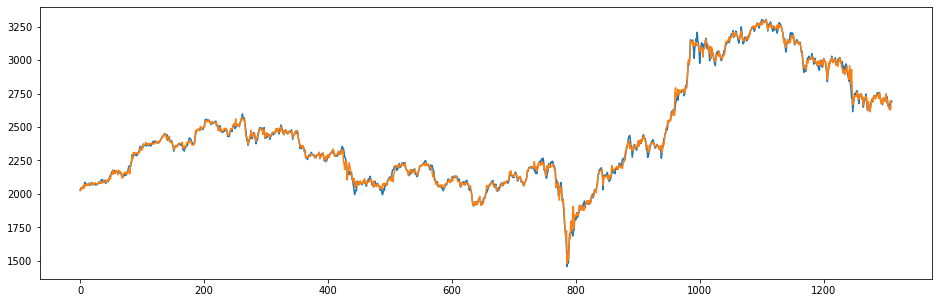

In [99]:
plt.figure(figsize=(16,5))
plt.plot(Y)
plt.plot(np.std(Y)*catboost_pred+np.mean(Y))

In [88]:
np.std(Y)

KOSPI    392.361069
dtype: float64

In [87]:
# ab=np.std(Y)*catboost_pred+np.mean(Y)
ab=[]
ab=np.std(Y)*catboost_pred+np.mean(Y)
ab

,0,KOSPI
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1306,NaN,NaN
1307,NaN,NaN
1308,NaN,NaN
1309,NaN,NaN


In [84]:
ab

,0,KOSPI
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1306,NaN,NaN
1307,NaN,NaN
1308,NaN,NaN
1309,NaN,NaN


In [ ]:
# plt.figure( figsize = (12, 11))

# plt.subplot(331)
# plt.plot(linear_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('linear')

# plt.subplot(332)
# plt.plot(ridge_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('ridge')

# plt.subplot(333)
# plt.plot(lasso_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('lasso')

# plt.subplot(334)
# plt.plot(elastic_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('elastic')

# plt.subplot(335)
# plt.plot(randomforest_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('randoomforest')

# plt.subplot(336)
# plt.plot(Xgboost_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('Xgboost')

# plt.subplot(337)
# plt.plot(catboost_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('catboost')

# plt.subplot(338)
# plt.plot(gradientboost_pred,'b')
# plt.plot(std_diff_1,'r')
# plt.title('gradientboost')
